# PROYECTO DE ML: Predicción del riesgo de sufrir un ictus

## ÍNDICE
1. Librerías utilizadas
2. Análisis de los datos  
    2.1. Análisis del target  
    2.2. Visualización  
    2.3. Transformación de variables categóricas  
    2.4. Información estadística de variables y correlación entre variables  
3. Elección de features y dividir en train y test   
    3.1. Correlación    
    3.2. Feature Importance  
4. Entrenamiento de modelos  

# 1.Librerías utilizadas

In [83]:
import numpy as np
import math
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
sns.set(color_codes=True)

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import xgboost
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score
import xgboost
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier, BalancedRandomForestClassifier

from collections import Counter

import pickle

import time as tm

import warnings
warnings.simplefilter('ignore')

# 2. Análisis de los datos

Cargamos en Dataset con los datos que vamos a utilizar

In [2]:
df=pd.read_csv('../data/raw_data/healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Vemos si hay missings en el dataset y los tipos de las columnas

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Hay missings en la columna de bmi, asi que vamos a sustituir los missings por la media más adelante

## 2.1. Análisis del target

Sacamos la información básica estadística del target

In [4]:
df['stroke'].describe()

count    5110.000000
mean        0.048728
std         0.215320
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

Distribución del target

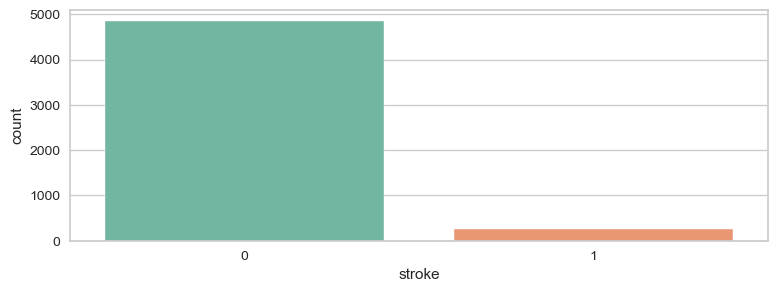

In [5]:
plt.figure(figsize=(9,3))
sns.countplot(x='stroke',
            data=df, palette='Set2');

**Desbalanceo de las clases del target**

In [6]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Vemos que las clases están muy descompensadas

## 2.2. Visualización

#### Visualización de todas las variables

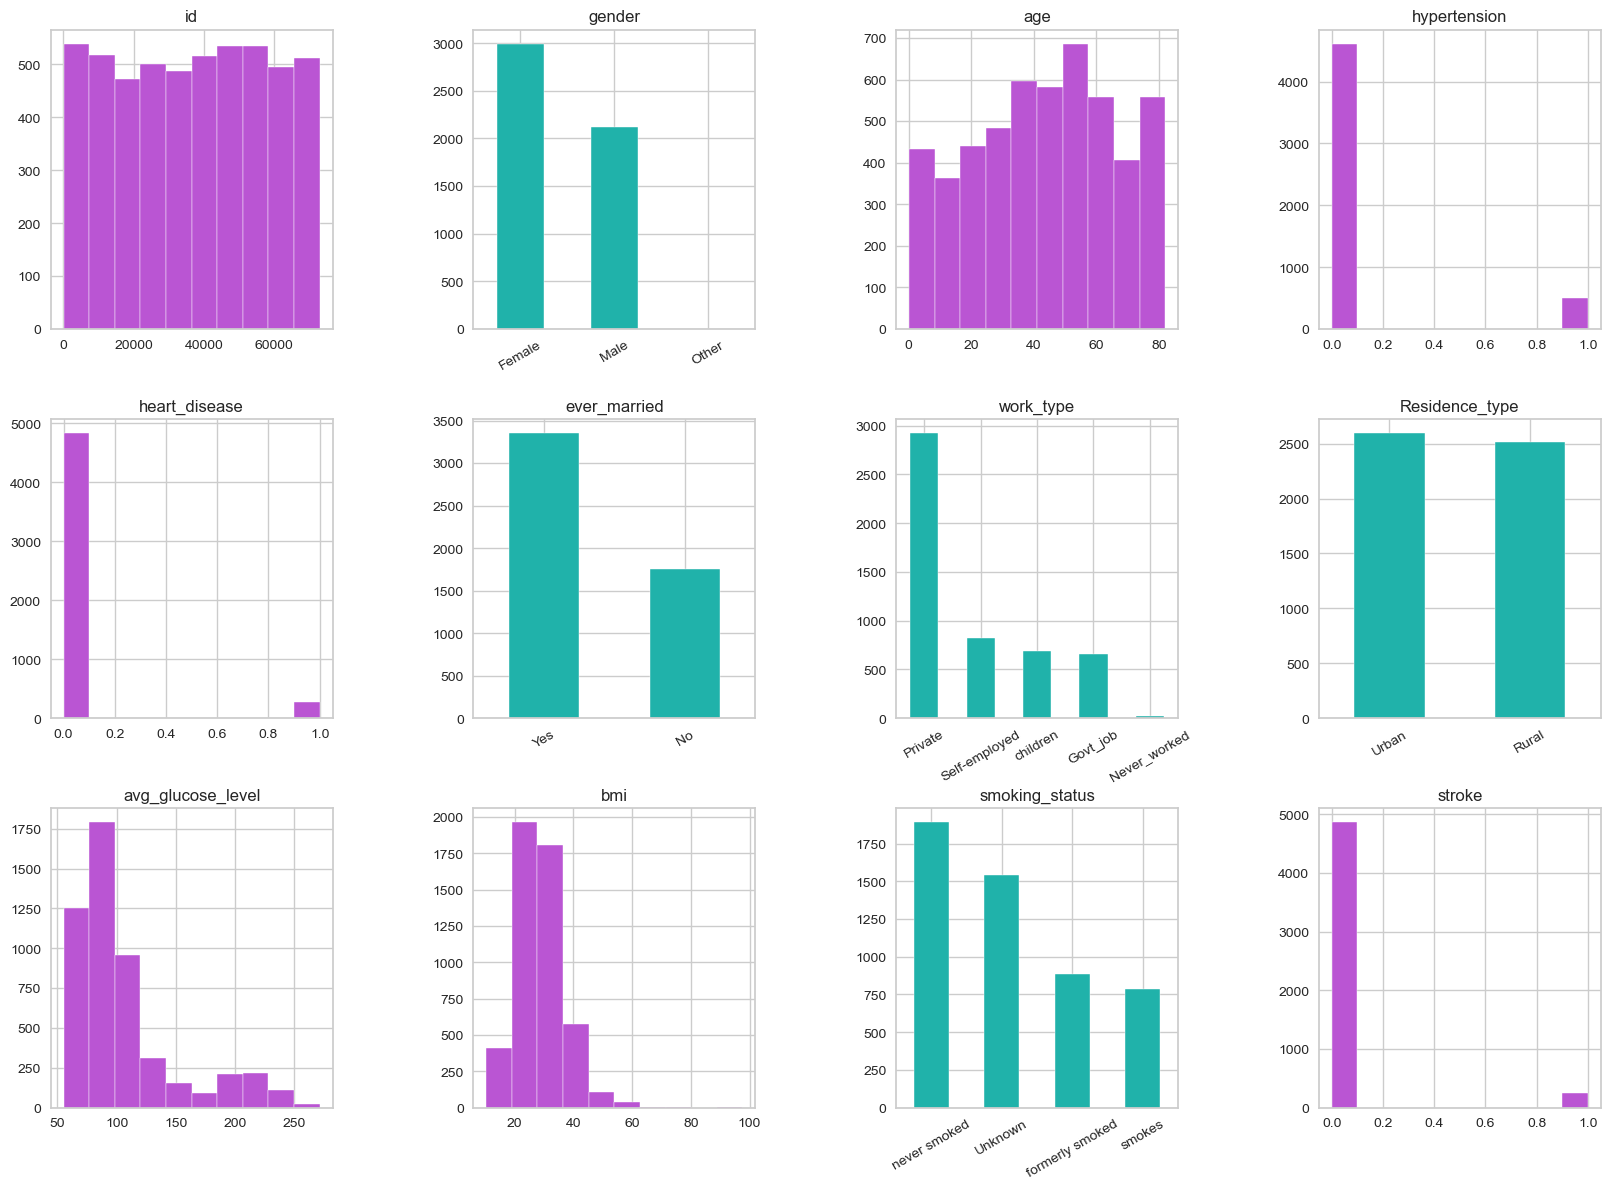

In [7]:
fig = plt.figure(figsize=(20, 14))
cols = 4
rows = np.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(int(rows), cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax, color='lightseagreen')
        plt.xticks(rotation=30)
    else:
        df[column].hist(axes=ax, color='mediumorchid')
        plt.xticks(rotation="horizontal")
plt.subplots_adjust(hspace=0.3, wspace=0.5)

#### Análisis de la variable gender en relación con el target

In [8]:
# Tabla de contingencia Clasificacion_peso / Genero
pd.crosstab(index=df['gender'],
            columns=df['stroke'])

stroke,0,1
gender,,
Female,2853,141
Male,2007,108
Other,1,0


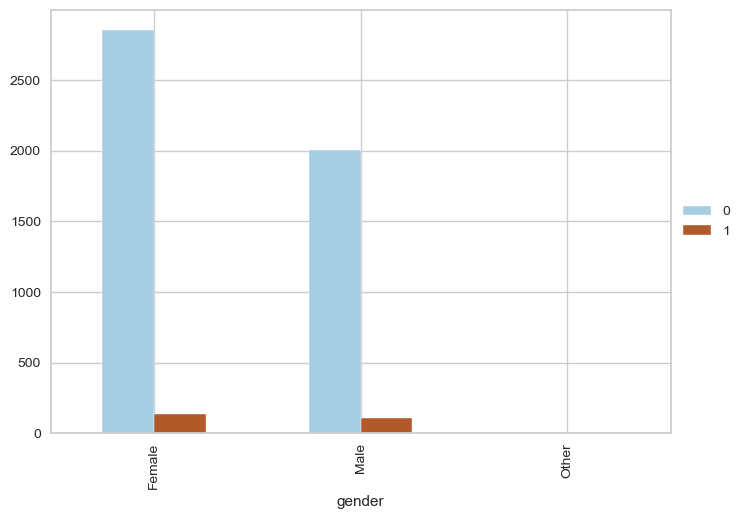

In [9]:
plot = pd.crosstab(index=df['gender'],
            columns=df['stroke']).plot(kind='bar', cmap='Paired')
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Vemos que una fila de la variable gender hay un dato de otros, por lo que vamos a tratarlo como si fuera un valor atípico y vamos a eliminarlo

In [10]:
indice = df[ df['gender'] == 'Other' ].index
df.drop(indice, inplace = True)
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

#### Análisis de la variable edad en relación con el target

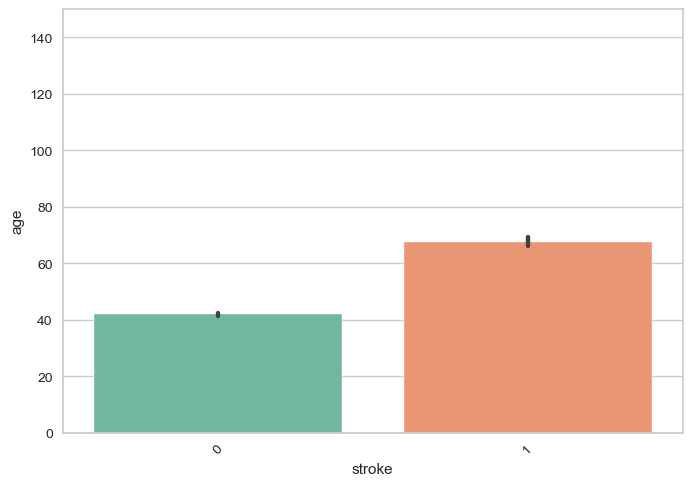

In [11]:
sns.barplot(x=df['stroke'], y=df['age'],palette='Set2')
plt.xticks(rotation=45)
plt.ylim(0,150);

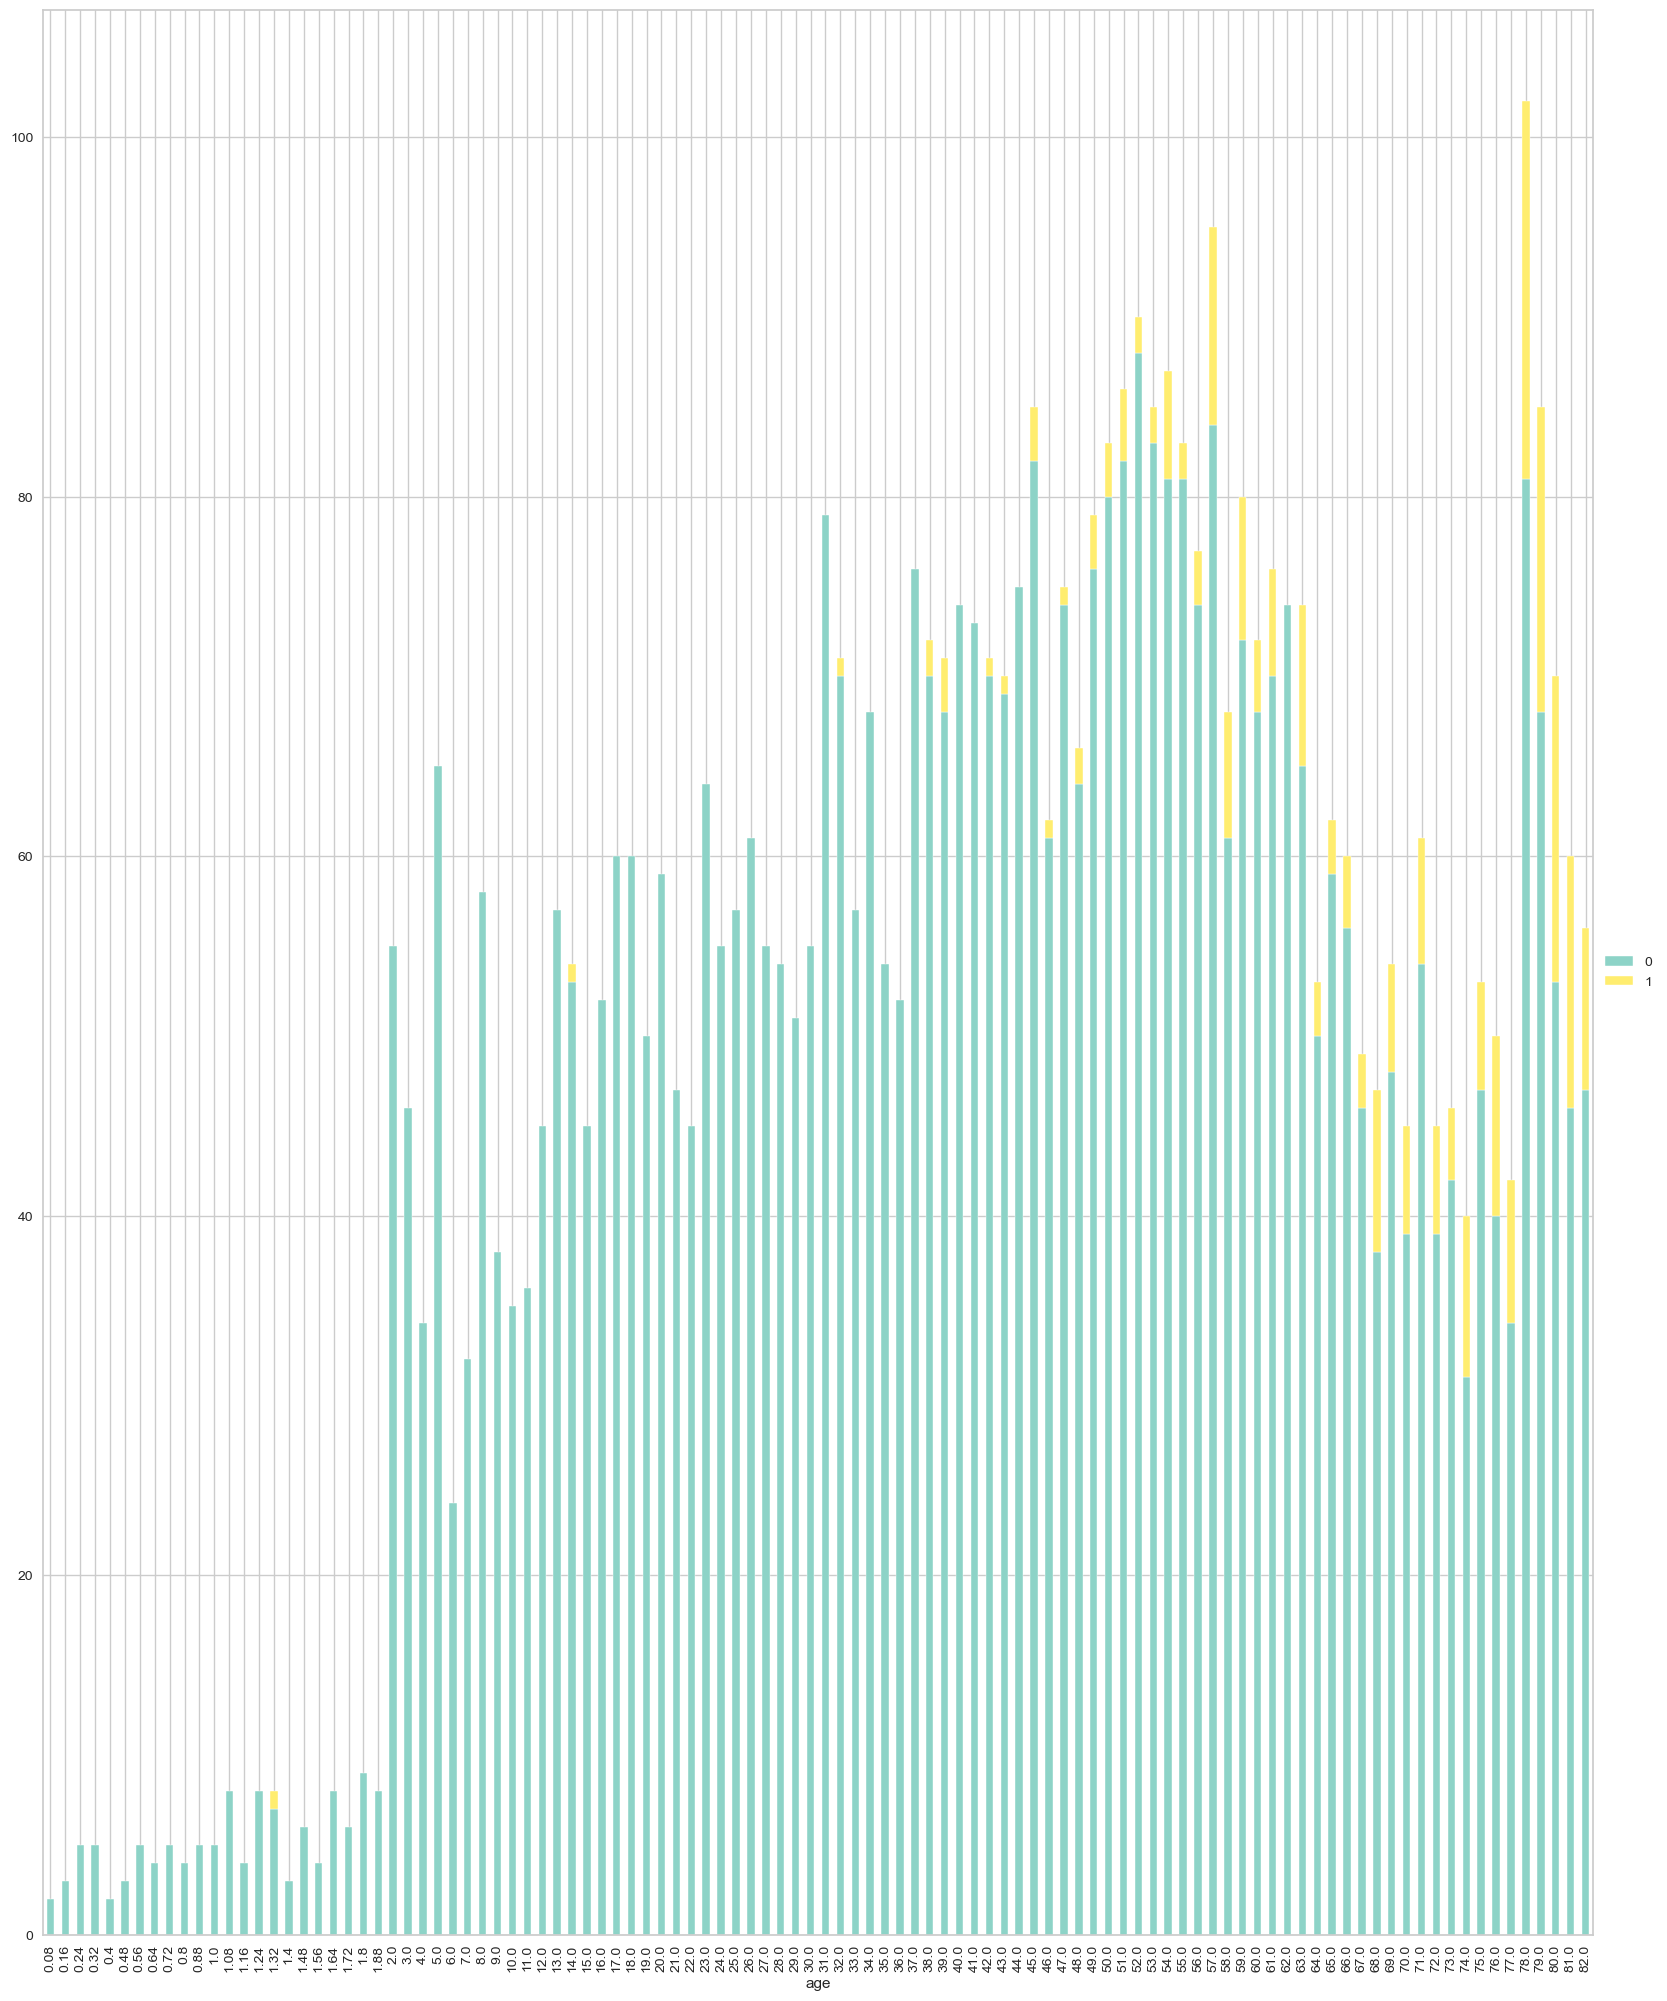

In [12]:
plot = pd.crosstab(index=df['age'],
            columns=df['stroke']).plot(kind='bar', stacked=True, cmap='Set3',figsize=(20,25))
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5));

#### Análisis de la variable hypertension con el target

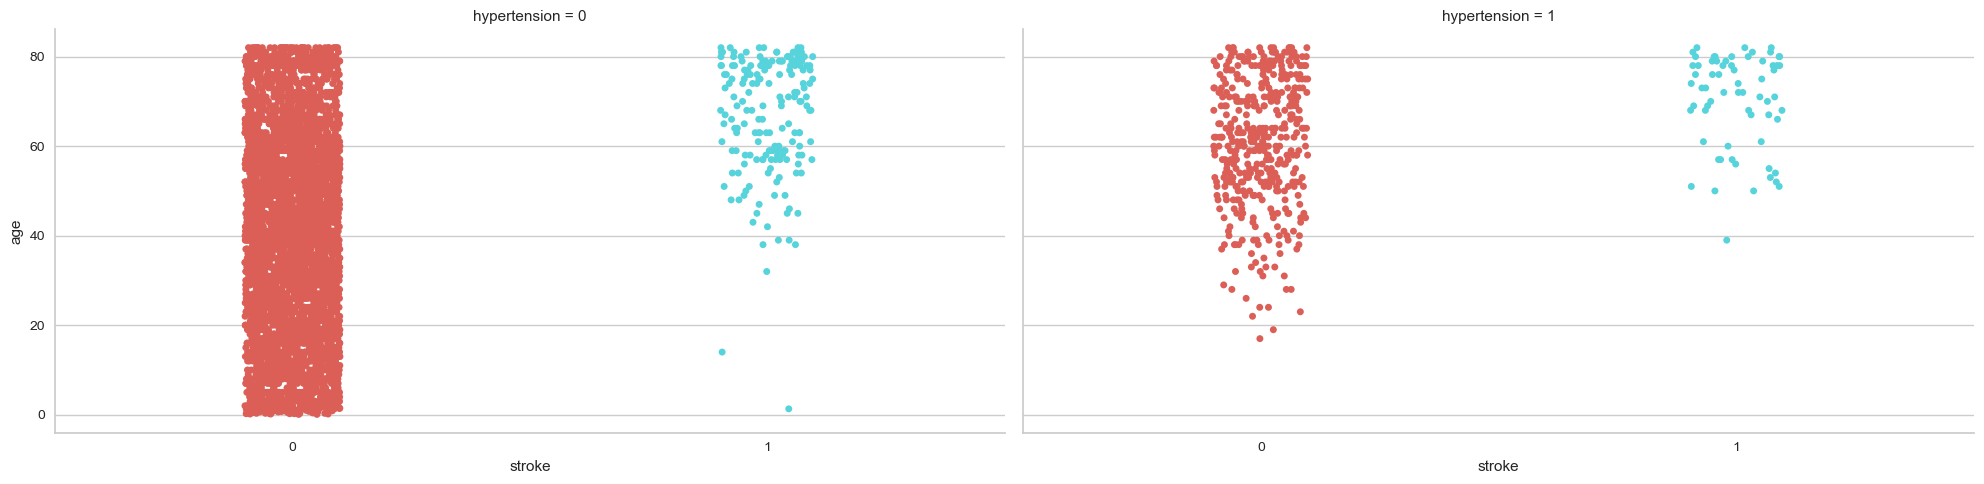

In [13]:
sns.catplot(x='stroke', y='age', col='hypertension', data=df, palette='hls', height = 5, aspect = 2)
plt.tight_layout()

#### Análisis de la variable heart_disease con el target

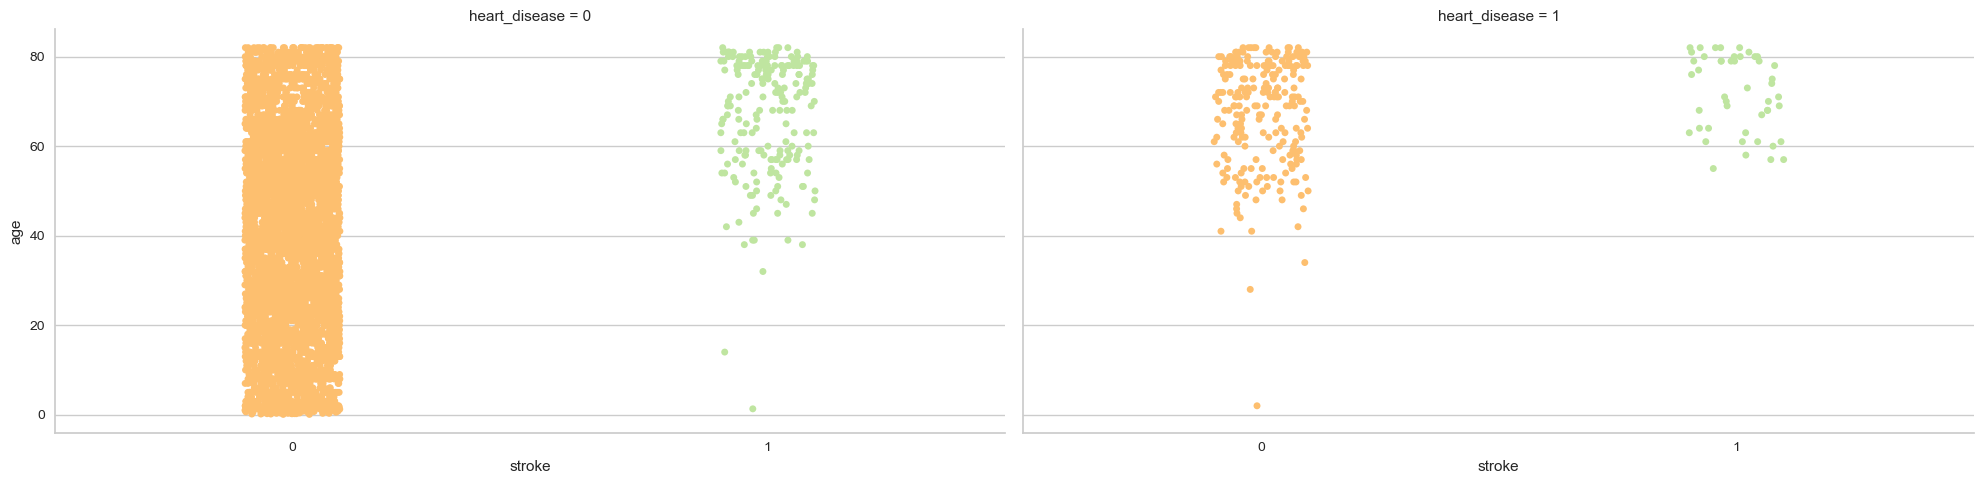

In [14]:
sns.catplot(x='stroke', y='age', col='heart_disease', data=df, palette='Spectral', height = 5, aspect = 2)
plt.tight_layout()

#### Análisis de la variable ever_married con el target

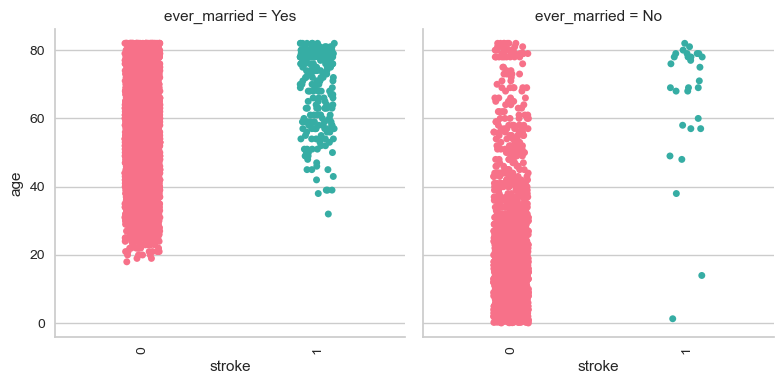

In [15]:
g=sns.catplot(x='stroke', y='age', col='ever_married', data=df, palette='husl', height = 4, aspect = 1)
g.set_xticklabels(rotation=90)
plt.tight_layout()

#### Relación de la variable avg_glucose_level con el target

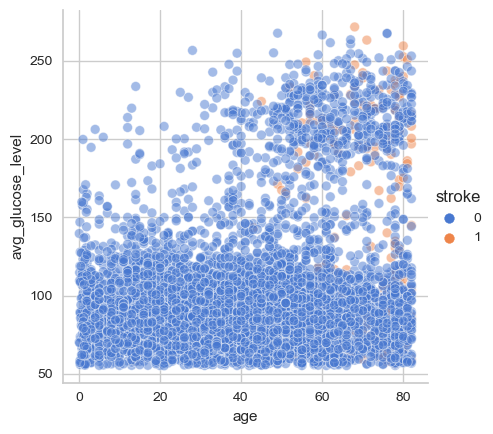

In [16]:
sns.relplot(data=df,
            x='age',
            y='avg_glucose_level',
            hue='stroke',
            sizes=(2, 300),
            alpha=.5, palette="muted",
            height=4.5);

#### Análisis de la relación entre la variable work_type con el target

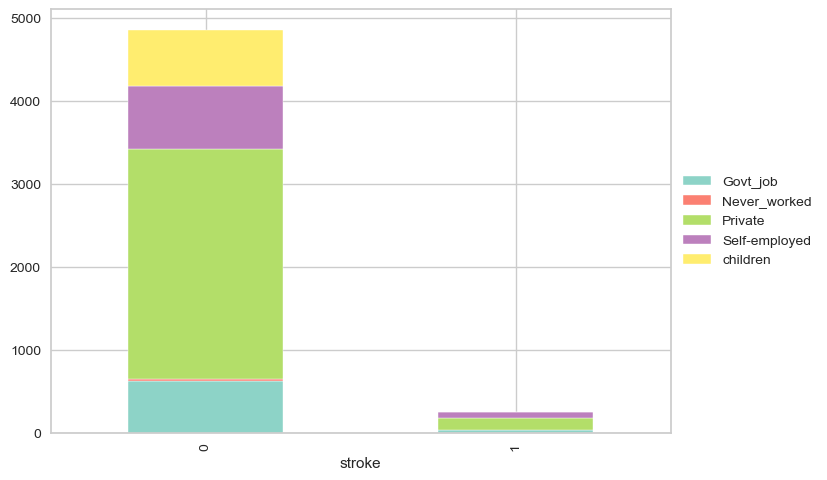

In [17]:
plot = pd.crosstab(index=df['stroke'],
            columns=df['work_type']).plot(kind='bar', stacked=True, cmap='Set3')
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Relación de la variable bmi con el target

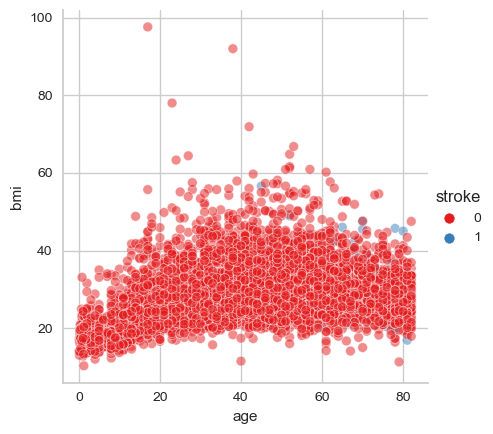

In [18]:
sns.relplot(data=df,
            x='age',
            y='bmi',
            hue='stroke',
            sizes=(2, 300),
            alpha=.5, palette="Set1",
            height=4.5);

#### Relación entre la variable Residence_type y el target

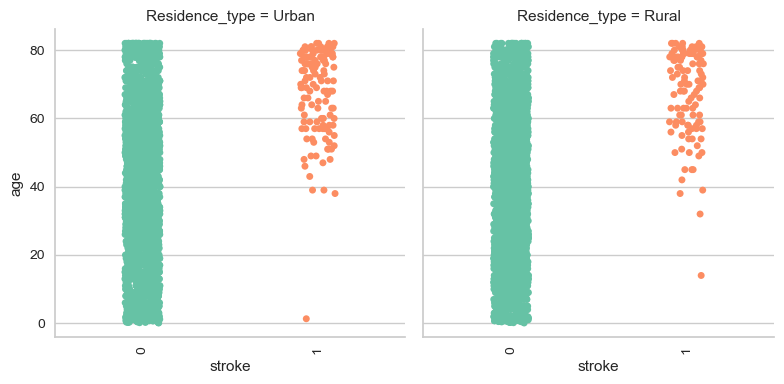

In [19]:
g=sns.catplot(x='stroke', y='age', col='Residence_type', data=df, palette='Set2', height = 4, aspect = 1)
g.set_xticklabels(rotation=90)
plt.tight_layout();

#### Relación de la variable smoking_status con el target

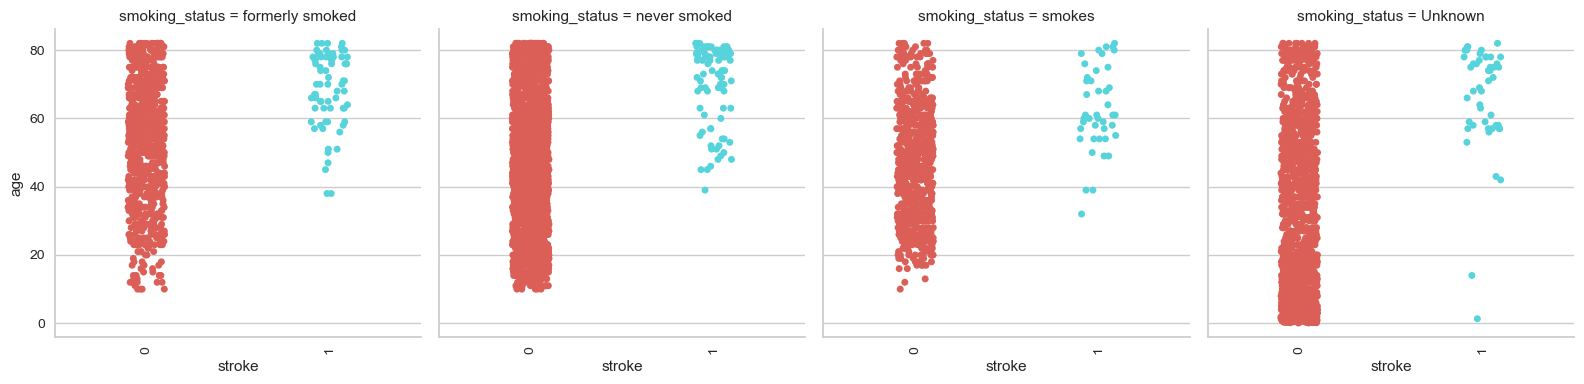

In [20]:
g=sns.catplot(x='stroke', y='age', col='smoking_status', data=df, palette='hls', height = 4, aspect = 1)
g.set_xticklabels(rotation=90)
plt.tight_layout();

## 2.3 Transformación de variables categóricas

Vemos cuáles son las categorías de cada una de las variables categóricas

In [21]:
for col in df:
    if df[col].dtype=='object':
        print(f'Valores de la columna({col}):')
        print(df[col].value_counts())
        print(f'Hay {len(df[col].unique())} tipos')
        print('\n')

Valores de la columna(gender):
Female    2994
Male      2115
Name: gender, dtype: int64
Hay 2 tipos


Valores de la columna(ever_married):
Yes    3353
No     1756
Name: ever_married, dtype: int64
Hay 2 tipos


Valores de la columna(work_type):
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Hay 5 tipos


Valores de la columna(Residence_type):
Urban    2596
Rural    2513
Name: Residence_type, dtype: int64
Hay 2 tipos


Valores de la columna(smoking_status):
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64
Hay 4 tipos




Más información del Dataset

In [22]:
def data_report(df):
    '''Esta función describe los campos de un dataframe: nombres, tipo, missings, valores únicos 
    y el porcentaje de valores únicos respecto al total de valores de esa variable (Cardin)'''
    
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T

In [23]:
data_report(df)

COL_N,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
DATA_TYPE,int64,object,float64,int64,int64,object,object,object,float64,float64,object,int64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.93,0.0,0.0
UNIQUE_VALUES,5109,2,104,2,2,2,5,2,3978,418,4,2
CARDIN (%),100.0,0.04,2.04,0.04,0.04,0.04,0.1,0.04,77.86,8.18,0.08,0.04


In [24]:
def df_encoding(df):
    
    #Columna Genero
    temp_dict_gender={'Female':1, 'Male':0}
    df['gender']=df.gender.replace(temp_dict_gender)
    
    
    #Columna ever_married
    temp_ever_married={'Yes':1, 'No':0}
    df['ever_married']=df.ever_married.replace(temp_ever_married)
    
    #Columna work_type
    temp_dict_worktype={'children':0, 'Never_worked':1,'Self-employed':3,'Private':4, 'Govt_job':2}
    df['work_type']=df.work_type.replace(temp_dict_worktype)
    
    #Columna Residence_type
    temp_dict_resident={'Urban':1, 'Rural':0}
    df['Residence_type']=df.Residence_type.replace(temp_dict_resident)

    
    #Columna smoking_status
    temp_dict_smoke={'Unknown':0, 'never smoked':1,'formerly smoked':2,'smokes':3}
    df['smoking_status']=df.smoking_status.replace(temp_dict_smoke)

   
    return df

In [25]:
df=df_encoding(df)

In [26]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,4,1,228.69,36.6,2,1
1,51676,1,61.0,0,0,1,3,0,202.21,NaN,1,1
2,31112,0,80.0,0,1,1,4,0,105.92,32.5,1,1
3,60182,1,49.0,0,0,1,4,1,171.23,34.4,3,1
4,1665,1,79.0,1,0,1,3,0,174.12,24.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,4,1,83.75,NaN,1,0
5106,44873,1,81.0,0,0,1,3,1,125.20,40.0,1,0
5107,19723,1,35.0,0,0,1,3,0,82.99,30.6,1,0
5108,37544,0,51.0,0,0,1,4,0,166.29,25.6,2,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   int64  
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   int64  
 6   work_type          5109 non-null   int64  
 7   Residence_type     5109 non-null   int64  
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                4908 non-null   float64
 10  smoking_status     5109 non-null   int64  
 11  stroke             5109 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 647.9 KB


### Guardamos el dataset procesado

In [28]:
df.to_csv('../data/processed_data/dataset_procesado.csv', sep=',', index=False)

## 2.4 Información estadística de las variables y correlación entre variables

In [29]:
df.describe()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000,5109.000000
mean,36513.985516,0.586025,43.229986,0.097475,0.054022,0.656293,3.031709,0.508123,106.140399,28.89456,1.179683,0.048738
std,21162.008804,0.492592,22.613575,0.296633,0.226084,0.474991,1.388428,0.499983,45.285004,7.85432,1.029998,0.215340
min,67.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,10.30000,0.000000,0.000000
25%,17740.000000,0.000000,25.000000,0.000000,0.000000,0.000000,2.000000,0.000000,77.240000,23.50000,0.000000,0.000000
50%,36922.000000,1.000000,45.000000,0.000000,0.000000,1.000000,4.000000,1.000000,91.880000,28.10000,1.000000,0.000000
75%,54643.000000,1.000000,61.000000,0.000000,0.000000,1.000000,4.000000,1.000000,114.090000,33.10000,2.000000,0.000000
max,72940.000000,1.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.60000,3.000000,1.000000


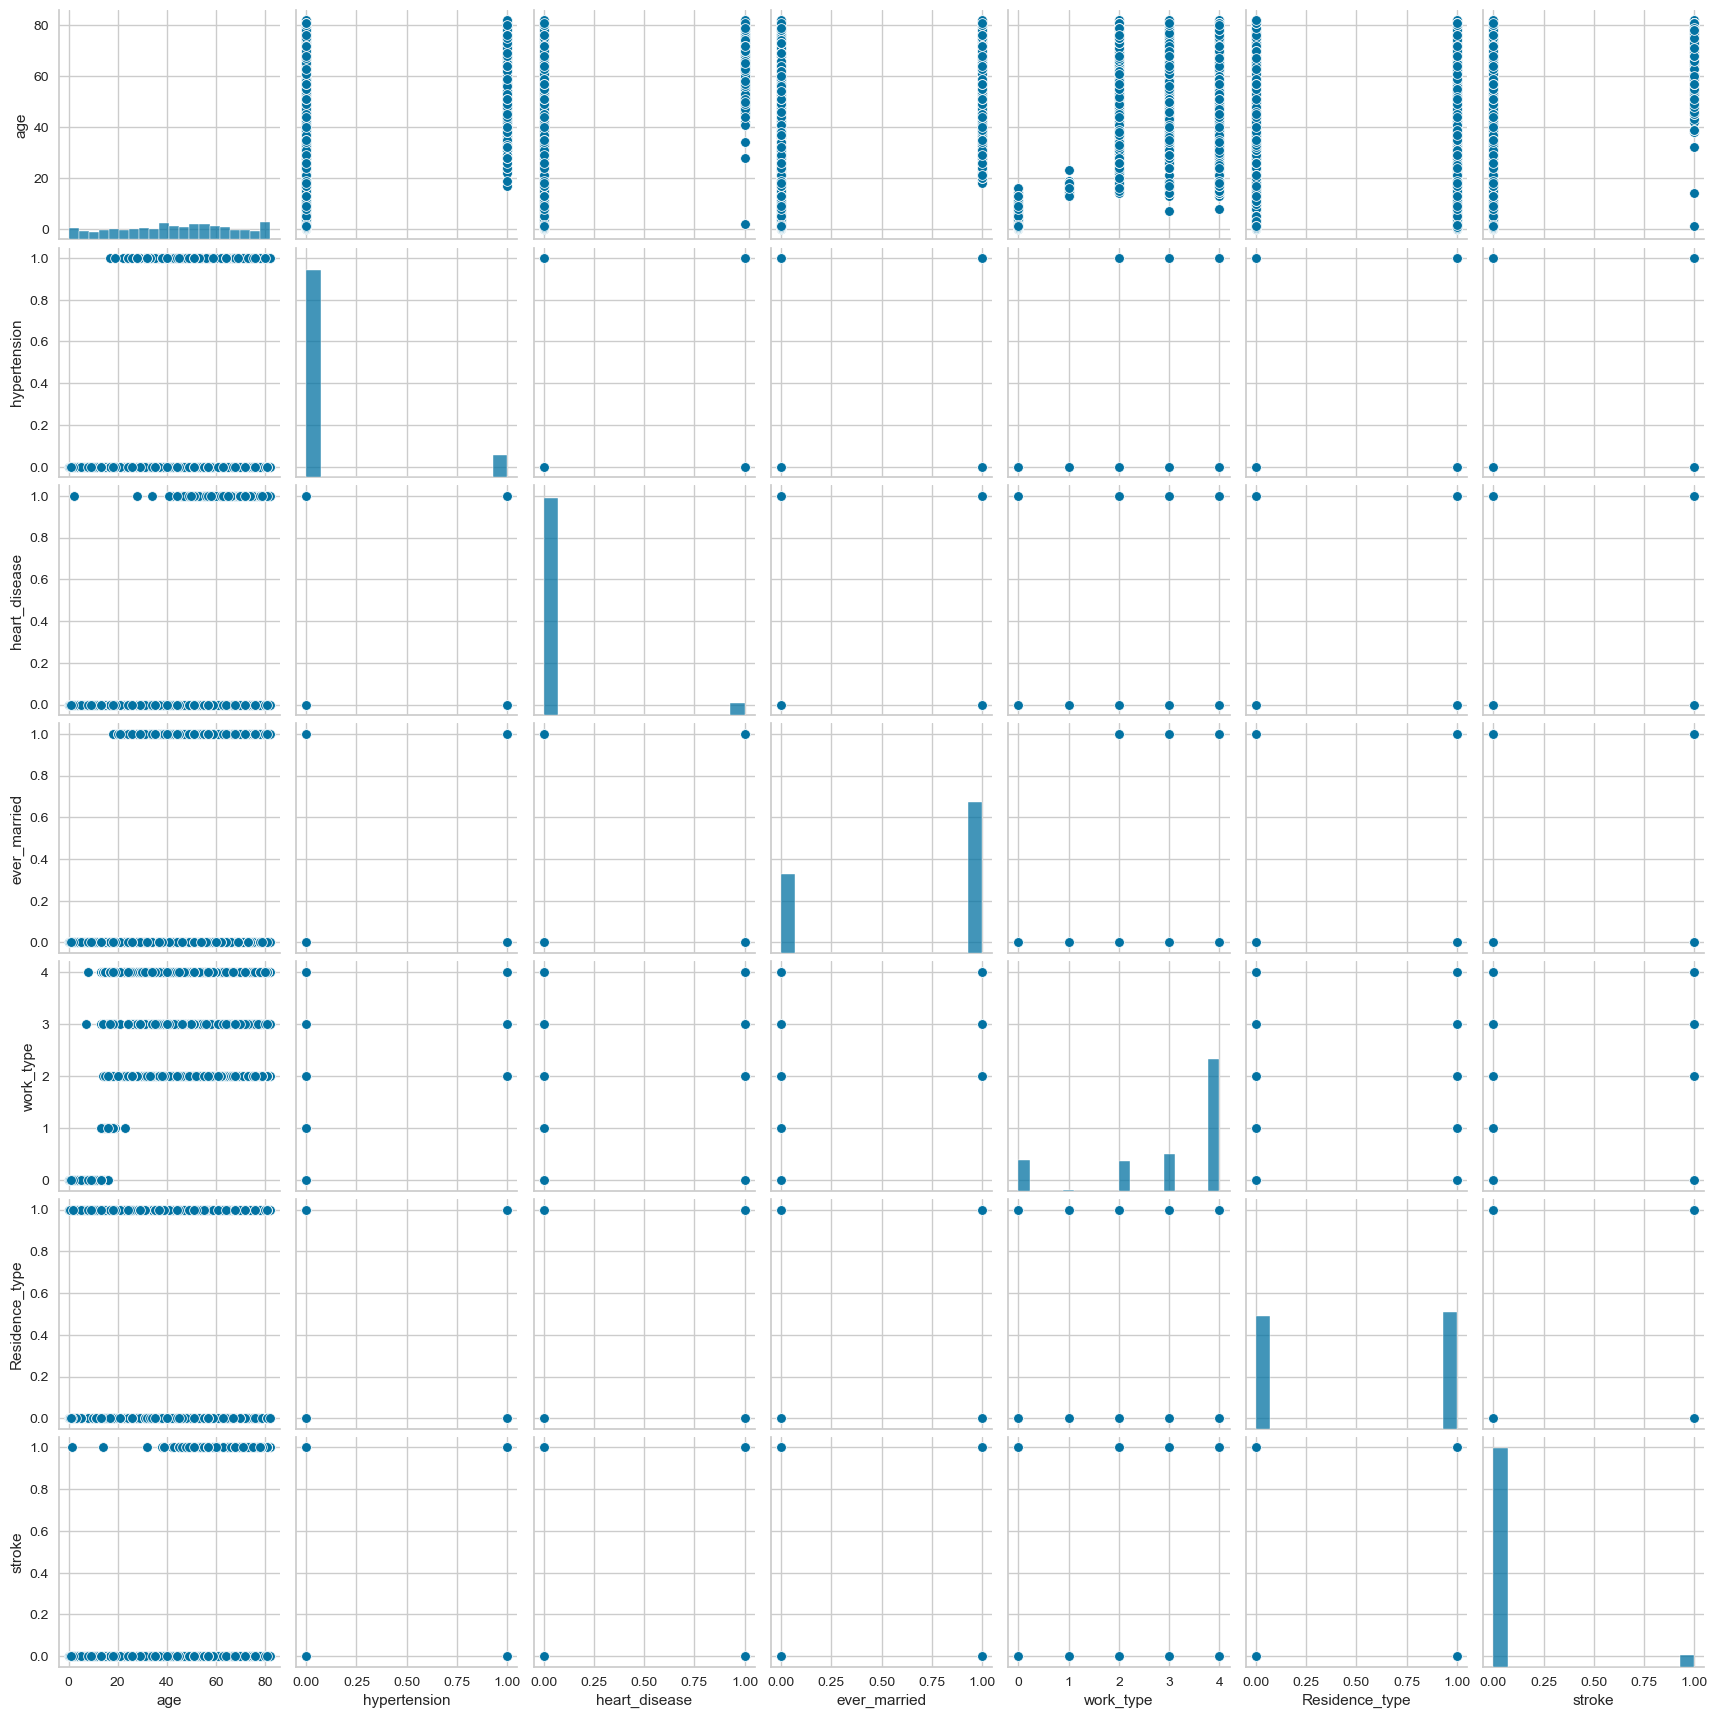

In [30]:
sns.pairplot(df[['age','hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type','stroke']]);

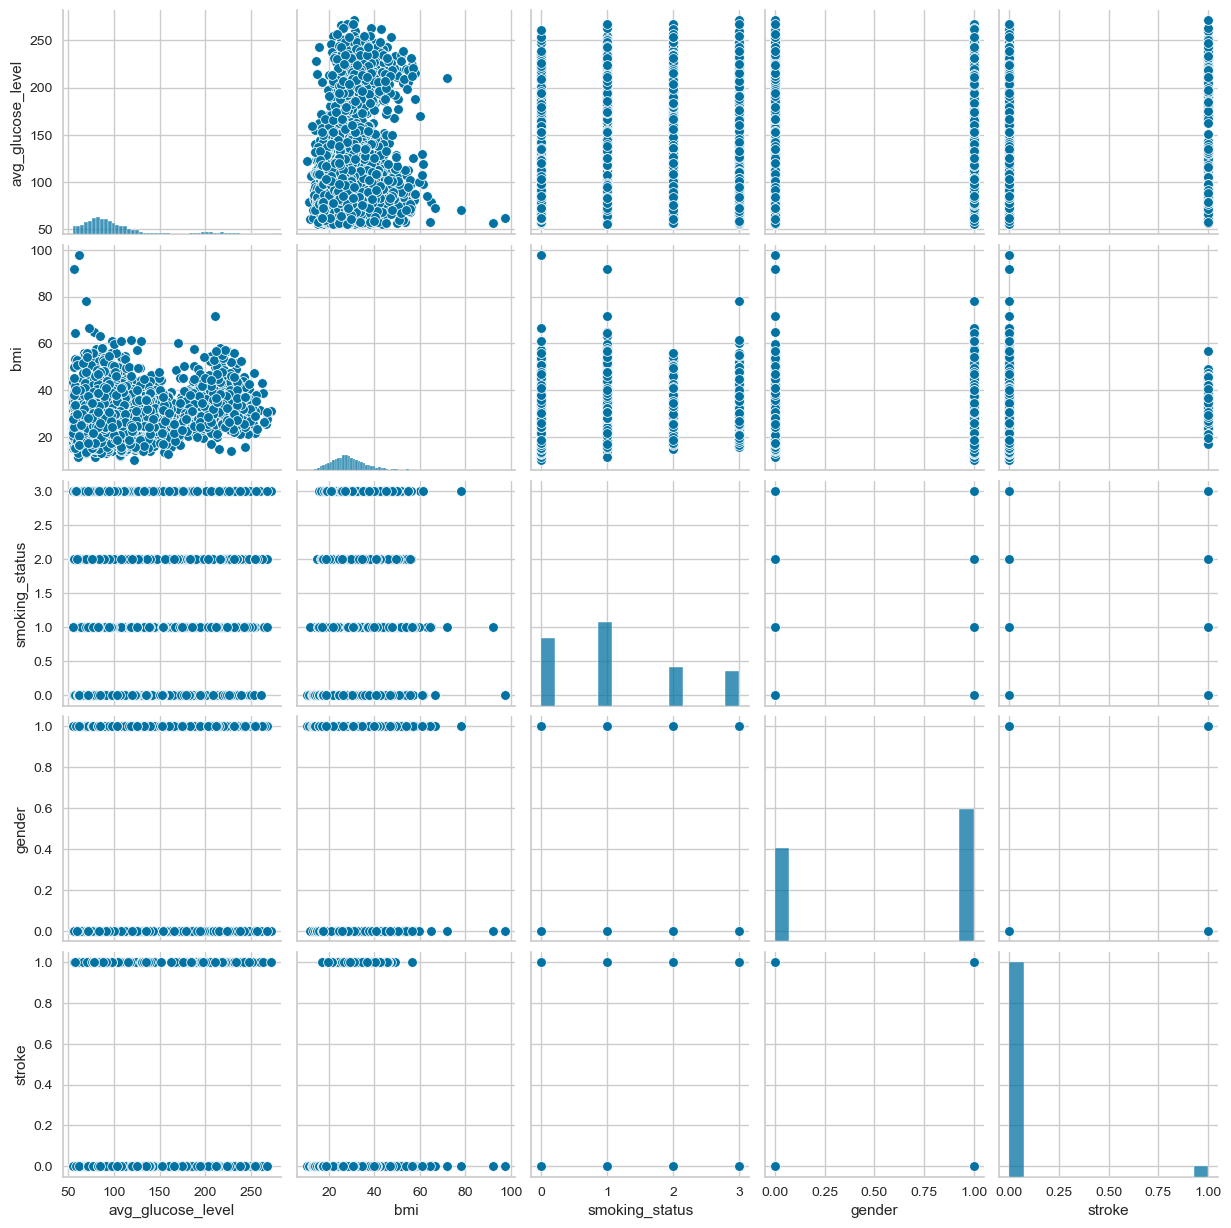

In [31]:
sns.pairplot(df[['avg_glucose_level','bmi','smoking_status','gender','stroke']]);

# 3. Elección de features y dividir en train y test

### Dividimos en train y test

In [32]:
X=df.drop(columns=['stroke'])
y=df['stroke']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                       random_state=42)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4087, 11)
(1022, 11)
(4087,)
(1022,)


### Imputar los missings

In [35]:
bmi_mean = X_train.bmi.mean()

In [36]:
def imputar_media(df, columna):
    valor_imputado = round(bmi_mean)
    es_nulo = df[columna].isna()
    df.loc[es_nulo,columna] = valor_imputado
    
    return df

In [37]:
X_train=imputar_media(X_train, 'bmi')

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4087 entries, 802 to 860
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4087 non-null   int64  
 1   gender             4087 non-null   int64  
 2   age                4087 non-null   float64
 3   hypertension       4087 non-null   int64  
 4   heart_disease      4087 non-null   int64  
 5   ever_married       4087 non-null   int64  
 6   work_type          4087 non-null   int64  
 7   Residence_type     4087 non-null   int64  
 8   avg_glucose_level  4087 non-null   float64
 9   bmi                4087 non-null   float64
 10  smoking_status     4087 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 383.2 KB


In [39]:
X_test=imputar_media(X_test, 'bmi')

In [40]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 4688 to 2902
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1022 non-null   int64  
 1   gender             1022 non-null   int64  
 2   age                1022 non-null   float64
 3   hypertension       1022 non-null   int64  
 4   heart_disease      1022 non-null   int64  
 5   ever_married       1022 non-null   int64  
 6   work_type          1022 non-null   int64  
 7   Residence_type     1022 non-null   int64  
 8   avg_glucose_level  1022 non-null   float64
 9   bmi                1022 non-null   float64
 10  smoking_status     1022 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 95.8 KB


#### Guardamos el dataset de X_train,X_test,y_train y y_test

In [41]:
X_train.to_csv('../data/processed_data/x_train_processed.csv', sep=',', index=False)
X_test.to_csv('../data/processed_data/x_test_processed.csv', sep=',', index=False)
y_train.to_csv('../data/processed_data/y_train_processed.csv', sep=',', index=False)
y_test.to_csv('../data/processed_data/y_test_processed.csv', sep=',', index=False)

## 3.1. Correlación

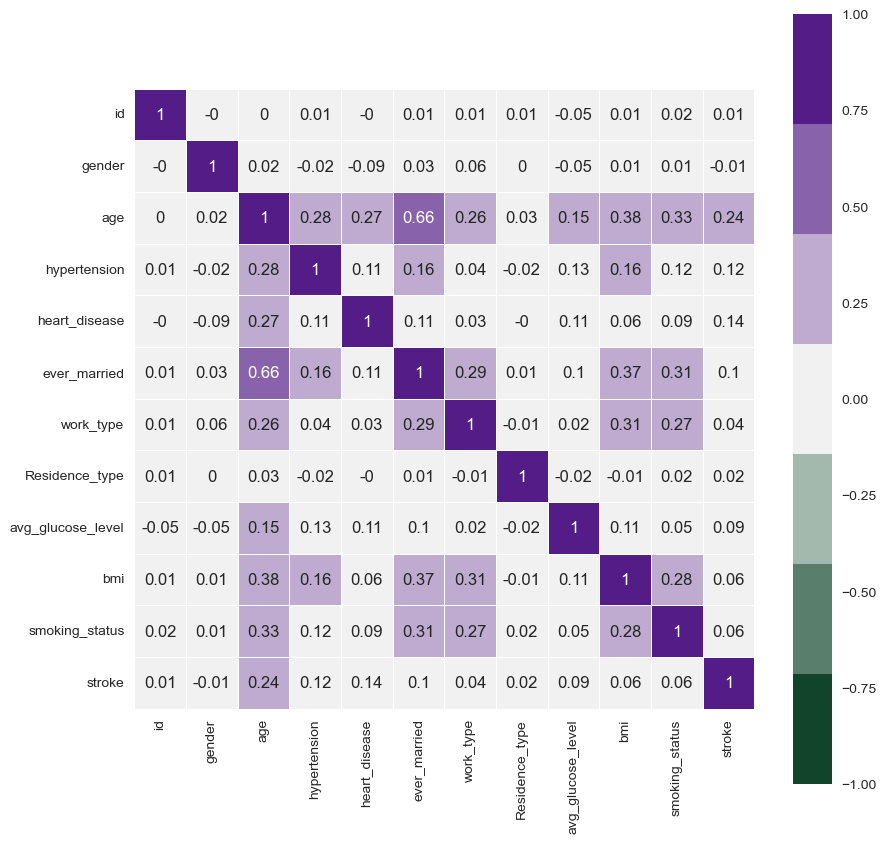

In [42]:
dftrain = df.loc[X_train.index]
plt.figure(figsize=(10,10))
sns.heatmap(np.round(dftrain.corr(method='spearman'),2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145,280,s=85,l=25,n=7),
            square=True,
            linewidths=0.5
           );

In [43]:
corr= np.abs(dftrain.corr(method='pearson')['stroke']).sort_values(ascending=False)
corr

stroke               1.000000
age                  0.238569
heart_disease        0.136884
avg_glucose_level    0.124874
hypertension         0.119408
ever_married         0.098107
work_type            0.064220
smoking_status       0.052101
bmi                  0.043601
Residence_type       0.015998
id                   0.010415
gender               0.007125
Name: stroke, dtype: float64

In [44]:
corr2= np.abs(dftrain.corr(method='spearman')['stroke']).sort_values(ascending=False)
corr2

stroke               1.000000
age                  0.241904
heart_disease        0.136884
hypertension         0.119408
ever_married         0.098107
avg_glucose_level    0.087573
smoking_status       0.056722
bmi                  0.056540
work_type            0.038900
Residence_type       0.015998
id                   0.010418
gender               0.007125
Name: stroke, dtype: float64

## 3.2. Feature importance estadístico

Realizamos un feature importance para ver qué importancia tiene cada feature

In [45]:
features = X_train.columns
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X_train, y_train)

pd.DataFrame({'column': features, 'score': sel.scores_}).sort_values('score', ascending=False)

,column,score
2,age,246.530828
4,heart_disease,78.003380
8,avg_glucose_level,64.708658
3,hypertension,59.087472
5,ever_married,39.699824
6,work_type,16.917044
10,smoking_status,11.118813
9,bmi,6.673200
7,Residence_type,1.045756
0,id,0.443198


### Feature reduction

In [46]:
drop_column_list=['id', 'Residence_type']

In [47]:
X_train.drop(columns=drop_column_list, inplace=True)
X_test.drop(columns=drop_column_list, inplace=True)

### Escalar

In [48]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(4087, 9)
(1022, 9)


# 4. Entrenar modelos

### Probamos qué modelo sale mejor con validación cruzada

Regresion Logistica
Precision: 0.48
Recall: 0.50
Accuracy: 0.95
f1_score: 0.49
Training time: 0.22

#######

Arbol de Decision
Precision: 0.54
Recall: 0.54
Accuracy: 0.91
f1_score: 0.54
Training time: 0.16

#######

Random Forest
Precision: 0.48
Recall: 0.50
Accuracy: 0.95
f1_score: 0.49
Training time: 5.09

#######

AdaBoost
Precision: 0.48
Recall: 0.50
Accuracy: 0.95
f1_score: 0.49
Training time: 2.12

#######

GBT
Precision: 0.57
Recall: 0.51
Accuracy: 0.95
f1_score: 0.51
Training time: 5.41

#######

xgboost
Precision: 0.61
Recall: 0.53
Accuracy: 0.95
f1_score: 0.54
Training time: 1.85

#######

LGBM
Precision: 0.58
Recall: 0.52
Accuracy: 0.95
f1_score: 0.52
Training time: 0.90

#######

CatBoost
Precision: 0.62
Recall: 0.51
Accuracy: 0.95
f1_score: 0.51
Training time: 30.46

#######



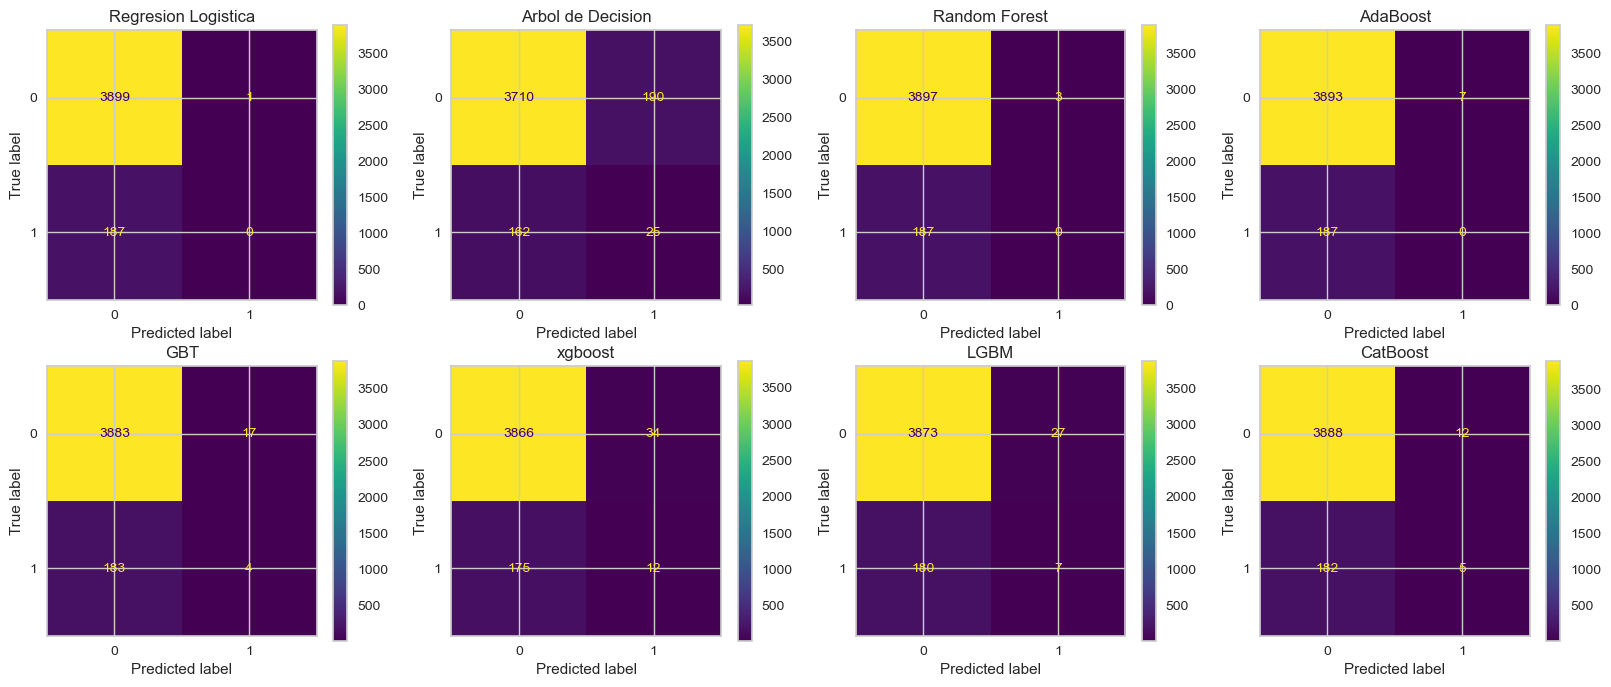

In [50]:
list_models_names_clas = ['Regresion Logistica','Arbol de Decision','Random Forest','AdaBoost', 'GBT', 'xgboost','LGBM','CatBoost']
list_models_clas = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(), GradientBoostingClassifier(),
                   xgboost.XGBClassifier(), LGBMClassifier(), CatBoostClassifier(verbose=False)]
classification_models = {zip(list_models_names_clas, list_models_clas)}

results_clas = {}
best_name_cls = "None"
best_clas = None
indice = 0
#fig, axs = plt.subplots(nrows=1, ncols=len(list_models_clas), figsize=(20, 8))
ncols = 4
nrows = math.ceil(len(list_models_clas)/ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 8))
num_cv= 5

for model_name,modelo in zip(list_models_names_clas, list_models_clas):
    t_zero = tm.time()
    print(model_name)
    results_clas[model_name] = {}
    modelo.fit(X_train_scaled,y_train)
    if num_cv < 2:
        y_pred_train_clas = modelo.predict(X_train_scaled)
        
    else:
        y_pred_train_clas = cross_val_predict(modelo,X_train_scaled,y_train, cv = num_cv, \
                                                method = "predict")
    # Metrics
    results_clas[model_name]["predictions"]= y_pred_train_clas.copy()
    for metric,evaluator in zip(["Precision","Recall","Accuracy","f1_score"],[precision_score, recall_score, \
                                                                              accuracy_score, f1_score]):
        if metric!='Accuracy':
            results_clas[model_name][metric] = evaluator(y_train,y_pred_train_clas, average='macro')
            print("%s: %.2f" %(metric, results_clas[model_name][metric]))
        else:
            results_clas[model_name][metric] = evaluator(y_train,y_pred_train_clas)
            print("%s: %.2f" %(metric, results_clas[model_name][metric]))
            
    plt.rc('font', size=10)
    row = indice // ncols
    col = indice % ncols
    #ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train_clas, ax=axs[indice]) 
    #axs[indice].set_title(model_name)
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train_clas, ax=axs[row, col]) 
    axs[row, col].set_title(model_name)

    print("Training time: %.2f\n" %(tm.time() - t_zero))
    print("#######\n")
    indice += 1

plt.show()

### Logistic Regression

Accuracy train: 0.9542451676046
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3900
           1       0.00      0.00      0.00       187

    accuracy                           0.95      4087
   macro avg       0.48      0.50      0.49      4087
weighted avg       0.91      0.95      0.93      4087



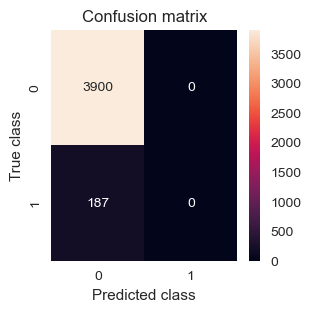



              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



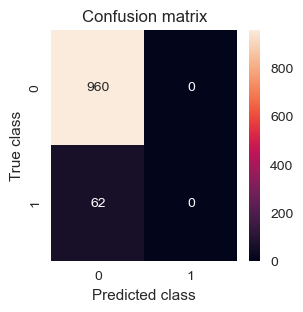

In [51]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

acc_train = accuracy_score(lr.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train)

y_pred_train_lr=lr.predict(X_train_scaled)
y_pred_test_lr=lr.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_lr, target_names=target_names))


def resultados(y, y_pred):
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(conf_matrix, xticklabels='auto', yticklabels='auto', annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

resultados(y_train, y_pred_train_lr)

print('\n')

print(classification_report(y_test, y_pred_test_lr, target_names=target_names))
resultados(y_test, y_pred_test_lr)


#### Utilizando el parámetro class_weight

Accuracy train: 0.7391729875214094
              precision    recall  f1-score   support

           0       0.99      0.74      0.84      3900
           1       0.13      0.82      0.22       187

    accuracy                           0.74      4087
   macro avg       0.56      0.78      0.53      4087
weighted avg       0.95      0.74      0.81      4087



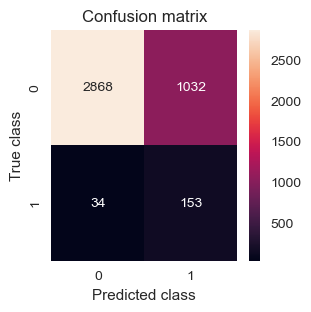



              precision    recall  f1-score   support

           0       0.98      0.73      0.84       960
           1       0.16      0.76      0.26        62

    accuracy                           0.73      1022
   macro avg       0.57      0.75      0.55      1022
weighted avg       0.93      0.73      0.80      1022



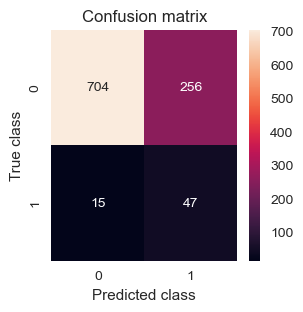

In [52]:
lr2 = LogisticRegression(class_weight= 'balanced')
lr2.fit(X_train_scaled, y_train)

acc_train = accuracy_score(lr2.predict(X_train_scaled), y_train)
acc_test = accuracy_score(lr2.predict(X_test_scaled), y_test)

print('Accuracy train:', acc_train)

y_pred_train_lr2=lr2.predict(X_train_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_lr2, target_names=target_names))

resultados(y_train, y_pred_train_lr2)

print('\n')

y_pred_test_lr2=lr2.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_test, y_pred_test_lr2, target_names=target_names))

resultados(y_test, y_pred_test_lr2)

#### Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 3900, 1: 187})
Distribution after resampling Counter({0: 187, 1: 187})
Accuracy train: 0.8368983957219251
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       187
           1       0.92      0.74      0.82       187

    accuracy                           0.84       374
   macro avg       0.85      0.84      0.84       374
weighted avg       0.85      0.84      0.84       374



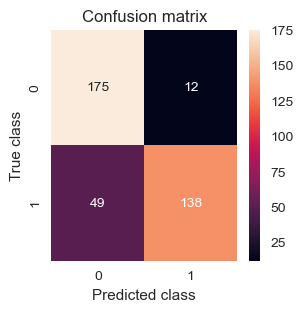

In [53]:
undersampling = NearMiss(n_neighbors=3)
X_train_res, y_train_res = undersampling.fit_resample(X_train_scaled, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

lr3 = LogisticRegression()
lr3.fit(X_train_res, y_train_res)

acc_train = accuracy_score(lr3.predict(X_train_res), y_train_res)

print('Accuracy train:', acc_train)

y_pred_train_lr3=lr3.predict(X_train_res)

target_names = ['0','1'] 
print(classification_report(y_train_res, y_pred_train_lr3, target_names=target_names))

resultados(y_train_res, y_pred_train_lr3)

#### Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 3900, 1: 187})
Distribution after resampling Counter({0: 3900, 1: 3900})
Accuracy train: 0.7794871794871795
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      3900
           1       0.76      0.82      0.79      3900

    accuracy                           0.78      7800
   macro avg       0.78      0.78      0.78      7800
weighted avg       0.78      0.78      0.78      7800



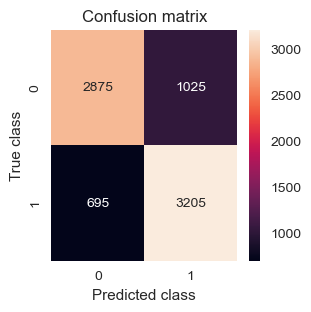



              precision    recall  f1-score   support

           0       0.98      0.73      0.84       960
           1       0.16      0.76      0.26        62

    accuracy                           0.74      1022
   macro avg       0.57      0.75      0.55      1022
weighted avg       0.93      0.74      0.80      1022



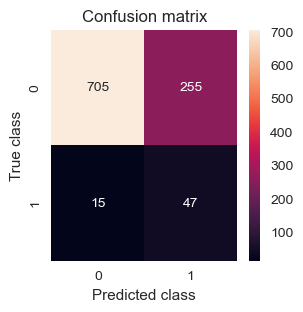

In [54]:
oversamplig =  RandomOverSampler()
X_train_res2, y_train_res2 = oversamplig.fit_resample(X_train_scaled, y_train)

print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res2)))

lr4 = LogisticRegression()
lr4.fit(X_train_res2, y_train_res2)

acc_train = accuracy_score(lr4.predict(X_train_res2), y_train_res2)

print('Accuracy train:', acc_train)

y_pred_train_lr4=lr4.predict(X_train_res2)

target_names = ['0','1'] 
print(classification_report(y_train_res2, y_pred_train_lr4, target_names=target_names))

resultados(y_train_res2, y_pred_train_lr4)

print('\n')

y_pred_test_lr4=lr4.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_test, y_pred_test_lr4, target_names=target_names))

resultados(y_test, y_pred_test_lr4)

#### Combinación de subsamplig y oversampling

Distribution before resampling Counter({0: 3900, 1: 187})
Distribution after resampling Counter({0: 3886, 1: 3886})
Accuracy train: 0.7938754503345342
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      3886
           1       0.77      0.84      0.80      3886

    accuracy                           0.79      7772
   macro avg       0.80      0.79      0.79      7772
weighted avg       0.80      0.79      0.79      7772



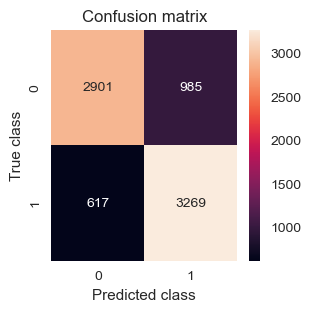



              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.16      0.76      0.26        62

    accuracy                           0.74      1022
   macro avg       0.57      0.75      0.55      1022
weighted avg       0.93      0.74      0.81      1022



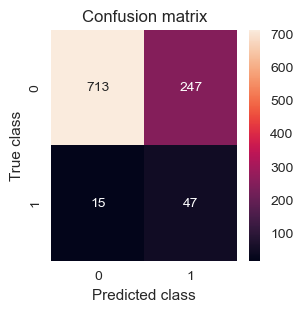

In [55]:
overs_uders = SMOTETomek()
X_train_res3, y_train_res3 = overs_uders.fit_resample(X_train_scaled, y_train)

print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res3)))

lr5 = LogisticRegression()
lr5.fit(X_train_res3, y_train_res3)

acc_train = accuracy_score(lr5.predict(X_train_res3), y_train_res3)

print('Accuracy train:', acc_train)

y_pred_train_lr5=lr5.predict(X_train_res3)

target_names = ['0','1'] 
print(classification_report(y_train_res3, y_pred_train_lr5, target_names=target_names))

resultados(y_train_res3, y_pred_train_lr5)

print('\n')

y_pred_test_lr5=lr5.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_test, y_pred_test_lr5, target_names=target_names))

resultados(y_test, y_pred_test_lr5)

### RandomForestClassifier

Accuracy train: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3900
           1       1.00      1.00      1.00       187

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087



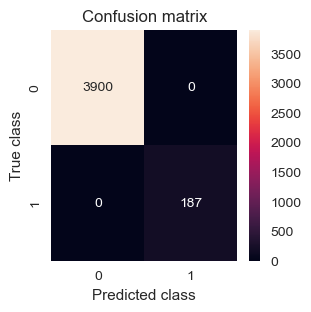



              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



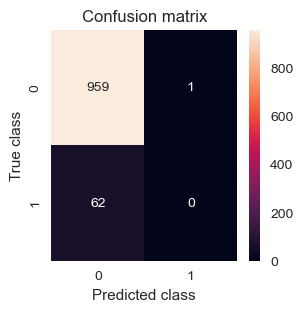

In [56]:
rdm_clas = RandomForestClassifier(class_weight= 'balanced')
rdm_clas.fit(X_train_scaled, y_train)

acc_train = accuracy_score(rdm_clas.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train)

y_pred_train_rdm=rdm_clas.predict(X_train_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_rdm, target_names=target_names))

resultados(y_train, y_pred_train_rdm)

print('\n')

y_pred_test_rdm=rdm_clas.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_test, y_pred_test_rdm, target_names=target_names))

resultados(y_test, y_pred_test_rdm)

#### Combinar oversampling y subsampling

Distribution before resampling Counter({0: 3900, 1: 187})
Distribution after resampling Counter({0: 3881, 1: 3881})
Accuracy train: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3881
           1       1.00      1.00      1.00      3881

    accuracy                           1.00      7762
   macro avg       1.00      1.00      1.00      7762
weighted avg       1.00      1.00      1.00      7762



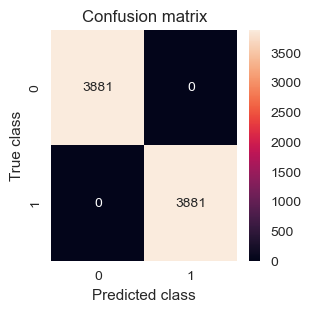



              precision    recall  f1-score   support

           0       0.95      0.95      0.95       960
           1       0.18      0.18      0.18        62

    accuracy                           0.90      1022
   macro avg       0.57      0.56      0.56      1022
weighted avg       0.90      0.90      0.90      1022



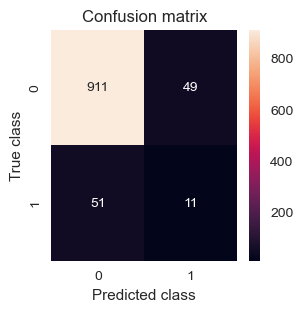

In [57]:
overs_uders = SMOTETomek()
X_train_res4, y_train_res4 = overs_uders.fit_resample(X_train_scaled, y_train)

print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res4)))

rdm_clas_re = RandomForestClassifier(class_weight= 'balanced')
rdm_clas_re.fit(X_train_res4, y_train_res4)

acc_train = accuracy_score(rdm_clas_re.predict(X_train_res4), y_train_res4)

print('Accuracy train:', acc_train)

y_pred_train_rdm_clas=rdm_clas_re.predict(X_train_res4)

target_names = ['0','1'] 
print(classification_report(y_train_res4, y_pred_train_rdm_clas, target_names=target_names))

resultados(y_train_res4, y_pred_train_rdm_clas)

print('\n')

y_pred_test_rdm_clas=rdm_clas_re.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_test, y_pred_test_rdm_clas, target_names=target_names))

resultados(y_test, y_pred_test_rdm_clas)

#### Undersampling de la clase mayoritaria

Distribution before resampling Counter({0: 3900, 1: 187})
Distribution after resampling Counter({0: 187, 1: 187})
Accuracy train: 1.0
              precision    recall  f1-score   support

           0       1.00      0.45      0.62       187
           1       0.65      1.00      0.79       187

    accuracy                           0.73       374
   macro avg       0.82      0.73      0.71       374
weighted avg       0.82      0.73      0.71       374



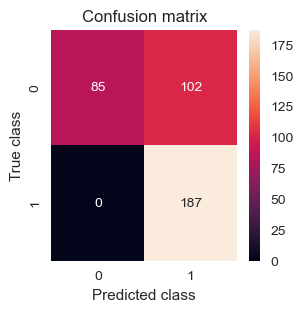

In [58]:
undersampling = undersamp= RandomUnderSampler(random_state=42)
X_train_res5, y_train_res5 = undersampling.fit_resample(X_train_scaled, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res5)))

rdm_clas_re2 = RandomForestClassifier(class_weight= 'balanced')
rdm_clas_re2.fit(X_train_res5, y_train_res5)

acc_train = accuracy_score(rdm_clas_re2.predict(X_train_res5), y_train_res5)

print('Accuracy train:', acc_train)

y_pred_train_rdm_clas2=rdm_clas_re2.predict(X_train_res)

target_names = ['0','1'] 
print(classification_report(y_train_res, y_pred_train_rdm_clas2, target_names=target_names))

resultados(y_train_res5, y_pred_train_rdm_clas2)

#### Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 3900, 1: 187})
Distribution after resampling Counter({0: 3900, 1: 3900})
Accuracy train: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3900
           1       1.00      1.00      1.00      3900

    accuracy                           1.00      7800
   macro avg       1.00      1.00      1.00      7800
weighted avg       1.00      1.00      1.00      7800



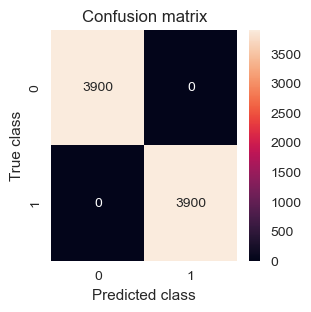



              precision    recall  f1-score   support

           0       0.95      0.95      0.95       960
           1       0.20      0.19      0.20        62

    accuracy                           0.91      1022
   macro avg       0.58      0.57      0.57      1022
weighted avg       0.90      0.91      0.90      1022



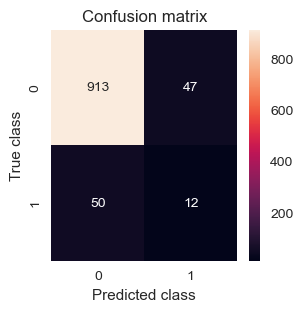

In [59]:
oversampling = SMOTE(random_state=42)
X_train_res6, y_train_res6 = oversampling.fit_resample(X_train_scaled, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res6)))

rdm_clas_re3 = RandomForestClassifier(class_weight= 'balanced')
rdm_clas_re3.fit(X_train_res6, y_train_res6)

acc_train = accuracy_score(rdm_clas_re3.predict(X_train_res6), y_train_res6)

print('Accuracy train:', acc_train)

y_pred_train_rdm_clas3=rdm_clas_re3.predict(X_train_res6)

target_names = ['0','1'] 
print(classification_report(y_train_res6, y_pred_train_rdm_clas3, target_names=target_names))

resultados(y_train_res6, y_pred_train_rdm_clas3)

print('\n')

y_pred_test_rdm_clas3=rdm_clas_re3.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_test, y_pred_test_rdm_clas3, target_names=target_names))

resultados(y_test, y_pred_test_rdm_clas3)

### Métodos de ensamblaje: BalancedBaggingClassifier

Accuracy train: 0.8348421825299731
Accuracy test: 0.8023483365949119
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3900
           1       0.21      0.98      0.35       187

    accuracy                           0.83      4087
   macro avg       0.61      0.90      0.63      4087
weighted avg       0.96      0.83      0.88      4087



              precision    recall  f1-score   support

           0       0.97      0.82      0.89       960
           1       0.16      0.55      0.25        62

    accuracy                           0.80      1022
   macro avg       0.56      0.68      0.57      1022
weighted avg       0.92      0.80      0.85      1022



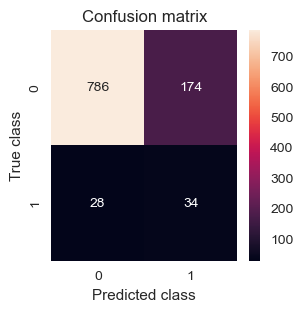

In [60]:
BalanBag = BalancedBaggingClassifier(sampling_strategy='auto',
                                replacement=False,
                                random_state=0)


BalanBag.fit(X_train_scaled, y_train)

acc_train = accuracy_score(BalanBag.predict(X_train_scaled), y_train)
acc_test = accuracy_score(BalanBag.predict(X_test_scaled), y_test)

print('Accuracy train:', acc_train)
print('Accuracy test:', acc_test)

y_pred_train_BalanBag=BalanBag.predict(X_train_scaled)


y_pred_test_BalanBag = BalanBag.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_BalanBag, target_names=target_names))

print('\n')


target_names = ['0','1']
print(classification_report(y_test, y_pred_test_BalanBag, target_names=target_names))


resultados(y_test, y_pred_test_BalanBag)

#### Ensamble de Modelos con Balanceo de clases

Accuracy train: 0.7859065329092244
Accuracy test: 0.7681017612524462
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      3900
           1       0.17      0.97      0.29       187

    accuracy                           0.79      4087
   macro avg       0.59      0.88      0.58      4087
weighted avg       0.96      0.79      0.85      4087



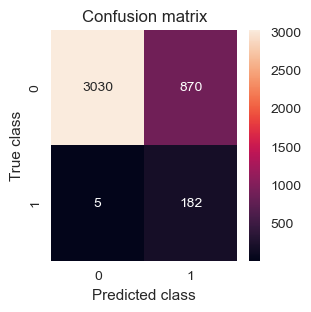



              precision    recall  f1-score   support

           0       0.98      0.77      0.86       960
           1       0.17      0.76      0.28        62

    accuracy                           0.77      1022
   macro avg       0.58      0.76      0.57      1022
weighted avg       0.93      0.77      0.83      1022



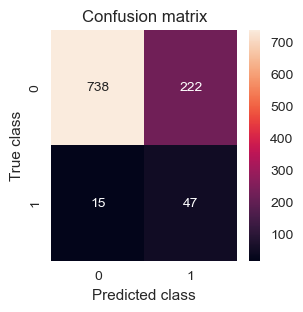

In [61]:
bbc = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(class_weight= 'balanced'),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)


bbc.fit(X_train_scaled, y_train)

acc_train = accuracy_score(bbc.predict(X_train_scaled), y_train)
acc_test = accuracy_score(bbc.predict(X_test_scaled), y_test)

print('Accuracy train:', acc_train)
print('Accuracy test:', acc_test)

y_pred_train_rdm_bbc=bbc.predict(X_train_scaled)
y_pred_test_rdm_bbc=bbc.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_rdm_bbc, target_names=target_names))

resultados(y_train, y_pred_train_rdm_bbc)

print('\n')

print(classification_report(y_test, y_pred_test_rdm_bbc, target_names=target_names))

resultados(y_test, y_pred_test_rdm_bbc)


#### Feature importance

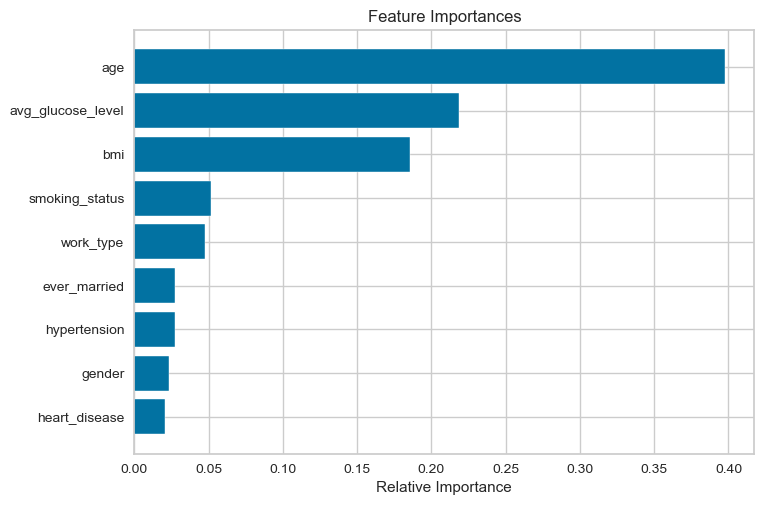

In [62]:
features = X_train.columns
importances = rdm_clas.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### CatboostClassifier

Accuracy train: 0.9779789576706631
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3900
           1       1.00      0.52      0.68       187

    accuracy                           0.98      4087
   macro avg       0.99      0.76      0.84      4087
weighted avg       0.98      0.98      0.97      4087



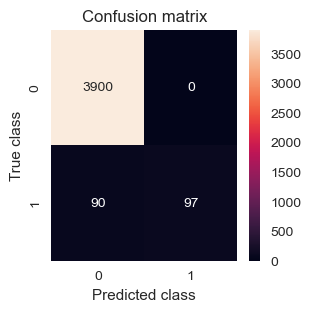



              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.33      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.64      0.51      0.50      1022
weighted avg       0.90      0.94      0.91      1022



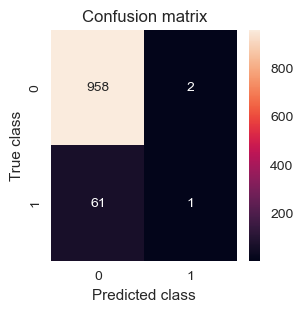

In [63]:
cb_clas = CatBoostClassifier(verbose=0)

cb_clas.fit(X_train_scaled, y_train)

acc_train_cb = accuracy_score(cb_clas.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train_cb)

y_pred_train_clas_cb=cb_clas.predict(X_train_scaled)

target_names = ['0','1']
print(classification_report(y_train, y_pred_train_clas_cb, target_names=target_names))


resultados(y_train, y_pred_train_clas_cb)

print('\n')

y_pred_test_clas_cb=cb_clas.predict(X_test_scaled)

target_names = ['0','1']
print(classification_report(y_test, y_pred_test_clas_cb, target_names=target_names))


resultados(y_test, y_pred_test_clas_cb)

#### Ensamble de Modelos con Balanceo de clases

Accuracy train: 0.7775874724736971
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      3900
           1       0.16      0.93      0.28       187

    accuracy                           0.78      4087
   macro avg       0.58      0.85      0.57      4087
weighted avg       0.96      0.78      0.84      4087



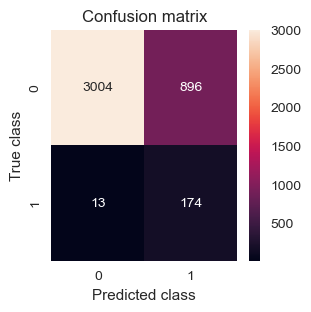

In [64]:
bbccb = BalancedBaggingClassifier(base_estimator=CatBoostClassifier(verbose=0),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)


bbccb.fit(X_train_scaled, y_train)

acc_train = accuracy_score(bbccb.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train)

y_pred_train_cb_bbc=bbccb.predict(X_train_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_cb_bbc, target_names=target_names))


resultados(y_train, y_pred_train_cb_bbc)

### LGBMClassifier

Accuracy train: 0.9718620014680694
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3900
           1       0.62      1.00      0.76       187

    accuracy                           0.97      4087
   macro avg       0.81      0.99      0.87      4087
weighted avg       0.98      0.97      0.97      4087



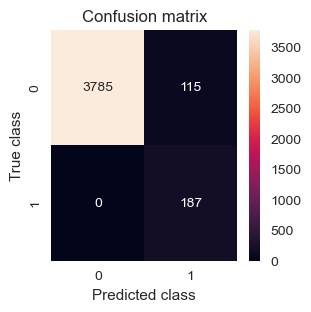

In [65]:
lgbm_clas=LGBMClassifier(
    objective='binary',
    class_weight='balanced',
)

lgbm_clas.fit(X_train_scaled, y_train)

acc_train_clas = accuracy_score(lgbm_clas.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train_clas)

predictions_train_lgbm_clas = lgbm_clas.predict(X_train_scaled)

print(classification_report(y_train, predictions_train_lgbm_clas))

resultados(y_train, predictions_train_lgbm_clas)

#### Ensamble de Modelos con Balanceo de clases

Accuracy train: 0.7954489845852704
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3900
           1       0.18      0.97      0.30       187

    accuracy                           0.80      4087
   macro avg       0.59      0.88      0.59      4087
weighted avg       0.96      0.80      0.85      4087



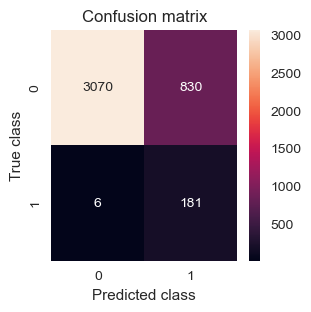

In [66]:
bbclgbm = BalancedBaggingClassifier(base_estimator=LGBMClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)


bbclgbm.fit(X_train_scaled, y_train)

acc_train = accuracy_score(bbclgbm.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train)

y_pred_train_lgbm_bbc=bbclgbm.predict(X_train_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_lgbm_bbc, target_names=target_names))

resultados(y_train, y_pred_train_lgbm_bbc)

### XGBClassifier

[18:37:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Accuracy train: 0.9033520919990213
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3900
           1       0.32      1.00      0.49       187

    accuracy                           0.90      4087
   macro avg       0.66      0.95      0.72      4087
weighted avg       0.97      0.90      0.93      4087



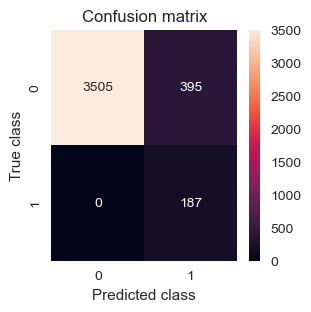



              precision    recall  f1-score   support

           0       0.96      0.88      0.92       960
           1       0.19      0.44      0.26        62

    accuracy                           0.85      1022
   macro avg       0.57      0.66      0.59      1022
weighted avg       0.91      0.85      0.88      1022



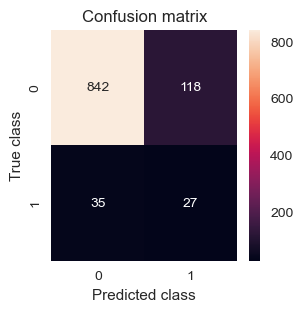

In [67]:
xgb_clas=xgboost.XGBClassifier(
    learning_rate =0.6,
 n_estimators=100,
 max_depth=3,
 objective= 'rank:pairwise',
 nthread=4,
 scale_pos_weight=1)

xgb_clas.fit(X_train_scaled, y_train)

acc_train_xgb_clas = accuracy_score(xgb_clas.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train_xgb_clas)

predictions_train_xgb_clas = xgb_clas.predict(X_train_scaled)

print(classification_report(y_train, predictions_train_xgb_clas))

resultados(y_train, predictions_train_xgb_clas)

print('\n')

predictions_test_xgb_clas = xgb_clas.predict(X_test_scaled)

print(classification_report(y_test, predictions_test_xgb_clas))

resultados(y_test, predictions_test_xgb_clas)

#### Ensamble de Modelos con Balanceo de clases

Accuracy train: 0.7978957670663078
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3900
           1       0.18      0.98      0.31       187

    accuracy                           0.80      4087
   macro avg       0.59      0.88      0.59      4087
weighted avg       0.96      0.80      0.86      4087



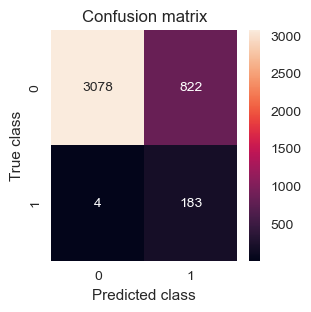

In [68]:
bbcxgb = BalancedBaggingClassifier(base_estimator=xgboost.XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)


bbcxgb.fit(X_train_scaled, y_train)

acc_train = accuracy_score(bbcxgb.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train)

y_pred_train_xgb_bbc=bbcxgb.predict(X_train_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_xgb_bbc, target_names=target_names))

resultados(y_train, y_pred_train_xgb_bbc)

### DecisionTreeClassifier

Accuracy train: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3900
           1       1.00      1.00      1.00       187

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087



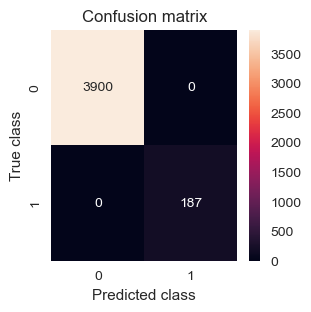

In [69]:
DTreeC=DecisionTreeClassifier(class_weight='balanced')

DTreeC.fit(X_train_scaled, y_train)

acc_train_DTreeC_clas = accuracy_score(DTreeC.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train_DTreeC_clas)

predictions_train_DTreeC_clas = DTreeC.predict(X_train_scaled)

print(classification_report(y_train, predictions_train_DTreeC_clas))

resultados(y_train, predictions_train_DTreeC_clas)

#### Ensamble de Modelos con Balanceo de clases

Accuracy train: 0.8348421825299731
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3900
           1       0.21      0.98      0.35       187

    accuracy                           0.83      4087
   macro avg       0.61      0.90      0.63      4087
weighted avg       0.96      0.83      0.88      4087



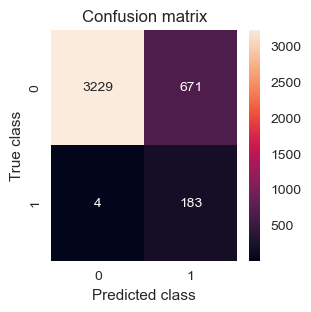

In [70]:
bbcDtreec = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)


bbcDtreec.fit(X_train_scaled, y_train)

acc_train = accuracy_score(bbcDtreec.predict(X_train_scaled), y_train)

print('Accuracy train:', acc_train)

y_pred_train_DTreeC_bbc=bbcDtreec.predict(X_train_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_DTreeC_bbc, target_names=target_names))


resultados(y_train, y_pred_train_DTreeC_bbc)

### Probamos a ver cuál es el mejor modelo con métodos de ensamblaje y validación cruzada

*******************************************************************************
base_estimator: RandomForestClassifier(class_weight='balanced')
Accuracy train: 0.7859065329092244
Accuracy test: 0.7681017612524462
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      3900
           1       0.17      0.97      0.29       187

    accuracy                           0.79      4087
   macro avg       0.59      0.88      0.58      4087
weighted avg       0.96      0.79      0.85      4087



              precision    recall  f1-score   support

           0       0.98      0.77      0.86       960
           1       0.17      0.76      0.28        62

    accuracy                           0.77      1022
   macro avg       0.58      0.76      0.57      1022
weighted avg       0.93      0.77      0.83      1022



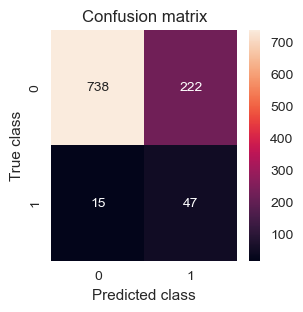

*******************************************************************************
base_estimator: LogisticRegression()
Accuracy train: 0.7438218742353805
Accuracy test: 0.7338551859099804
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3900
           1       0.13      0.82      0.23       187

    accuracy                           0.74      4087
   macro avg       0.56      0.78      0.54      4087
weighted avg       0.95      0.74      0.82      4087



              precision    recall  f1-score   support

           0       0.98      0.73      0.84       960
           1       0.15      0.76      0.26        62

    accuracy                           0.73      1022
   macro avg       0.57      0.75      0.55      1022
weighted avg       0.93      0.73      0.80      1022



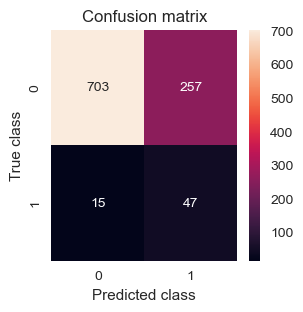

*******************************************************************************
base_estimator: DecisionTreeClassifier()
Accuracy train: 0.8348421825299731
Accuracy test: 0.8023483365949119
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3900
           1       0.21      0.98      0.35       187

    accuracy                           0.83      4087
   macro avg       0.61      0.90      0.63      4087
weighted avg       0.96      0.83      0.88      4087



              precision    recall  f1-score   support

           0       0.97      0.82      0.89       960
           1       0.16      0.55      0.25        62

    accuracy                           0.80      1022
   macro avg       0.56      0.68      0.57      1022
weighted avg       0.92      0.80      0.85      1022



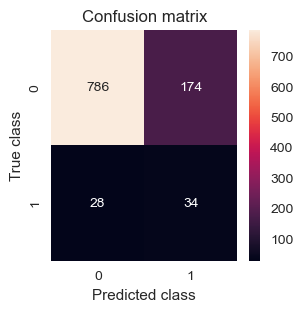

*******************************************************************************
base_estimator: GradientBoostingClassifier()
Accuracy train: 0.7722045510154147
Accuracy test: 0.7573385518590998
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      3900
           1       0.16      0.94      0.27       187

    accuracy                           0.77      4087
   macro avg       0.58      0.85      0.57      4087
weighted avg       0.96      0.77      0.84      4087



              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.17      0.79      0.28        62

    accuracy                           0.76      1022
   macro avg       0.58      0.77      0.57      1022
weighted avg       0.93      0.76      0.82      1022



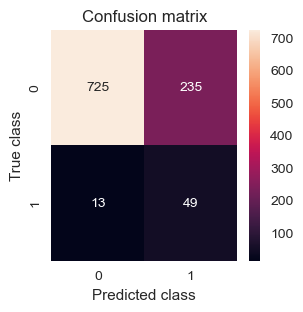

*******************************************************************************
base_estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy train: 0.7978957670663078
Accuracy test: 0.7671232876712328
              precision    recall  f1-score   support

           0       1.00     

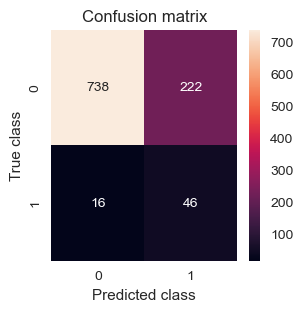

*******************************************************************************
base_estimator: LGBMClassifier()
Accuracy train: 0.7954489845852704
Accuracy test: 0.761252446183953
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3900
           1       0.18      0.97      0.30       187

    accuracy                           0.80      4087
   macro avg       0.59      0.88      0.59      4087
weighted avg       0.96      0.80      0.85      4087



              precision    recall  f1-score   support

           0       0.98      0.76      0.86       960
           1       0.17      0.73      0.27        62

    accuracy                           0.76      1022
   macro avg       0.57      0.74      0.56      1022
weighted avg       0.93      0.76      0.82      1022



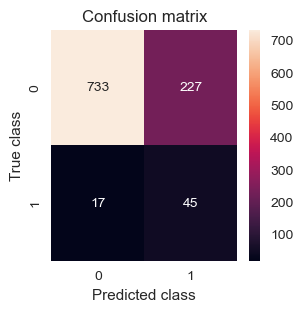

*******************************************************************************
base_estimator: <catboost.core.CatBoostClassifier object at 0x0000016A11474D00>
Accuracy train: 0.7775874724736971
Accuracy test: 0.7563600782778865
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      3900
           1       0.16      0.93      0.28       187

    accuracy                           0.78      4087
   macro avg       0.58      0.85      0.57      4087
weighted avg       0.96      0.78      0.84      4087



              precision    recall  f1-score   support

           0       0.98      0.75      0.85       960
           1       0.17      0.79      0.28        62

    accuracy                           0.76      1022
   macro avg       0.58      0.77      0.57      1022
weighted avg       0.93      0.76      0.82      1022



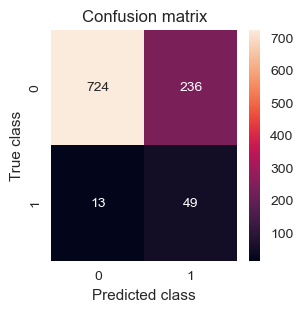

*******************************************************************************
***   R E S U M E N   D E   M É T R I C A S   D E   L O S   M O D E L O S   ***
*******************************************************************************
modelo: RandomForestClassifier(class_weight='balanced')
	acc_train: 0.7859065329092244		acc_test: 0.7681017612524462
	train_1_recall: 0.9732620320855615	test_1_recall: 0.7580645161290323
	train_1_f1: 0.2937853107344633		test_1_f: 0.283987915407855
modelo: LogisticRegression()
	acc_train: 0.7438218742353805		acc_test: 0.7338551859099804
	train_1_recall: 0.8181818181818182	test_1_recall: 0.7580645161290323
	train_1_f1: 0.2261640798226164		test_1_f: 0.2568306010928962
modelo: DecisionTreeClassifier()
	acc_train: 0.8348421825299731		acc_test: 0.8023483365949119
	train_1_recall: 0.9786096256684492	test_1_recall: 0.5483870967741935
	train_1_f1: 0.35158501440922185		test_1_f: 0.2518518518518519
modelo: GradientBoostingClassifier()
	acc_train: 0.772204551015

In [71]:
base_estimator_list= [RandomForestClassifier(class_weight= 'balanced'),
                      LogisticRegression(),
                      DecisionTreeClassifier(), 
                      GradientBoostingClassifier(),
                      xgboost.XGBClassifier(),
                      LGBMClassifier(), 
                      CatBoostClassifier(verbose=False)]

modelos_dict = {}

for base_estimator in base_estimator_list:

    print('*******************************************************************************')
    print('base_estimator:', base_estimator)

    param_grid_dict = {
        'base_estimator': [base_estimator],
        'sampling_strategy': ['auto'],
        'replacement': [False],
        'random_state': [0]
    }

    bbc = BalancedBaggingClassifier()

    grid_search_cv = GridSearchCV(bbc, param_grid_dict, n_jobs=8, cv=5)
    grid_search_cv.fit(X_train_scaled, y_train)

    acc_train = accuracy_score(grid_search_cv.predict(X_train_scaled), y_train)
    acc_test = accuracy_score(grid_search_cv.predict(X_test_scaled), y_test)
    print('Accuracy train:', acc_train)
    print('Accuracy test:', acc_test)

    y_pred_train_bbc=grid_search_cv.predict(X_train_scaled)


    y_pred_test_bbc = grid_search_cv.predict(X_test_scaled)

    target_names = ['0','1'] 

    classification_report_train = classification_report(y_train, y_pred_train_bbc, target_names=target_names, output_dict=True)
    classification_report_test = classification_report(y_test, y_pred_test_bbc, target_names=target_names, output_dict=True)

    print(classification_report(y_train, y_pred_train_bbc, target_names=target_names, output_dict=False))
    print('\n')
    print(classification_report(y_test, y_pred_test_bbc, target_names=target_names, output_dict=False))

    modelos_dict[f'{base_estimator}'] = {'acc_train': acc_train, 'acc_test': acc_test,
                                         'train_1_recall': classification_report_train['1']['recall'],
                                         'train_1_f1': classification_report_train['1']['f1-score'],
                                         'test_1_recall': classification_report_test['1']['recall'],
                                         'test_1_f1': classification_report_test['1']['f1-score']}

    resultados(y_test, y_pred_test_bbc)

print('*******************************************************************************')
print('***   R E S U M E N   D E   M É T R I C A S   D E   L O S   M O D E L O S   ***')
print('*******************************************************************************')
for modelo in modelos_dict.keys():
    acc_train = modelos_dict[modelo]['acc_train']
    acc_test = modelos_dict[modelo]['acc_test']
    train_1_recall = modelos_dict[modelo]['train_1_recall']
    train_1_f1 = modelos_dict[modelo]['train_1_f1']
    test_1_recall = modelos_dict[modelo]['test_1_recall']
    test_1_f1 = modelos_dict[modelo]['test_1_f1']
    print(f'modelo: {modelo}')
    print(f'\tacc_train: {acc_train}\t\tacc_test: {acc_test}')
    print(f'\ttrain_1_recall: {train_1_recall}\ttest_1_recall: {test_1_recall}')
    print(f'\ttrain_1_f1: {train_1_f1}\t\ttest_1_f: {test_1_f1}')

Los mejores resutados son con el CatboostClassifier

### Métodos de ensamblaje: EasyEmsembleClassifier

In [72]:
easyEsem = EasyEnsembleClassifier(random_state=0)
easyEsem.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(random_state=0)

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      3900
           1       0.12      0.95      0.21       187

    accuracy                           0.68      4087
   macro avg       0.56      0.81      0.51      4087
weighted avg       0.96      0.68      0.77      4087



              precision    recall  f1-score   support

           0       0.99      0.66      0.79       960
           1       0.14      0.85      0.24        62

    accuracy                           0.68      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.93      0.68      0.76      1022



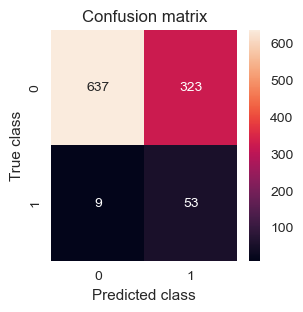

In [73]:
y_pred_train_easyEsem=easyEsem.predict(X_train_scaled)


y_pred_test_easyEsem = easyEsem.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_easyEsem, target_names=target_names))

print('\n')


target_names = ['0','1']
print(classification_report(y_test, y_pred_test_easyEsem, target_names=target_names))


resultados(y_test, y_pred_test_easyEsem)

#### Probamos varios modelos con EasyEnsembleClassifier con validación cruzada

*******************************************************************************
base_estimator: RandomForestClassifier(class_weight='balanced')
Accuracy train: 0.7293858575972596
Accuracy test: 0.7103718199608611
              precision    recall  f1-score   support

           0       1.00      0.72      0.83      3900
           1       0.14      1.00      0.25       187

    accuracy                           0.73      4087
   macro avg       0.57      0.86      0.54      4087
weighted avg       0.96      0.73      0.81      4087



              precision    recall  f1-score   support

           0       0.98      0.70      0.82       960
           1       0.15      0.82      0.26        62

    accuracy                           0.71      1022
   macro avg       0.57      0.76      0.54      1022
weighted avg       0.93      0.71      0.79      1022



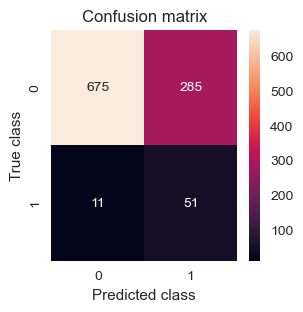

*******************************************************************************
base_estimator: AdaBoostClassifier()
Accuracy train: 0.6794714949840959
Accuracy test: 0.675146771037182
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      3900
           1       0.12      0.95      0.21       187

    accuracy                           0.68      4087
   macro avg       0.56      0.81      0.51      4087
weighted avg       0.96      0.68      0.77      4087



              precision    recall  f1-score   support

           0       0.99      0.66      0.79       960
           1       0.14      0.85      0.24        62

    accuracy                           0.68      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.93      0.68      0.76      1022



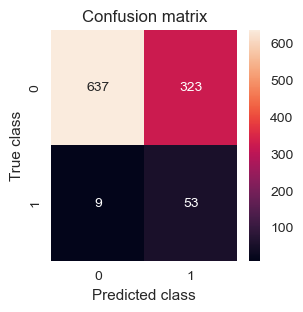

*******************************************************************************
base_estimator: LogisticRegression()
Accuracy train: 0.7313432835820896
Accuracy test: 0.726027397260274
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3900
           1       0.13      0.83      0.22       187

    accuracy                           0.73      4087
   macro avg       0.56      0.78      0.53      4087
weighted avg       0.95      0.73      0.81      4087



              precision    recall  f1-score   support

           0       0.98      0.72      0.83       960
           1       0.15      0.77      0.26        62

    accuracy                           0.73      1022
   macro avg       0.57      0.75      0.54      1022
weighted avg       0.93      0.73      0.80      1022



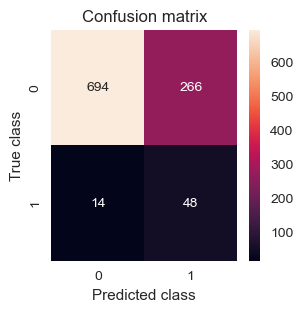

*******************************************************************************
base_estimator: DecisionTreeClassifier()
Accuracy train: 0.7739172987521409
Accuracy test: 0.7524461839530333
              precision    recall  f1-score   support

           0       1.00      0.76      0.87      3900
           1       0.17      1.00      0.29       187

    accuracy                           0.77      4087
   macro avg       0.58      0.88      0.58      4087
weighted avg       0.96      0.77      0.84      4087



              precision    recall  f1-score   support

           0       0.97      0.76      0.85       960
           1       0.15      0.68      0.25        62

    accuracy                           0.75      1022
   macro avg       0.56      0.72      0.55      1022
weighted avg       0.92      0.75      0.82      1022



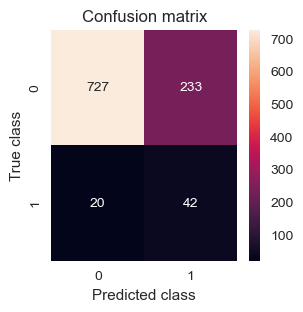

*******************************************************************************
base_estimator: GradientBoostingClassifier()
Accuracy train: 0.7205774406655249
Accuracy test: 0.7103718199608611
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      3900
           1       0.14      0.98      0.24       187

    accuracy                           0.72      4087
   macro avg       0.57      0.84      0.54      4087
weighted avg       0.96      0.72      0.80      4087



              precision    recall  f1-score   support

           0       0.99      0.70      0.82       960
           1       0.15      0.84      0.26        62

    accuracy                           0.71      1022
   macro avg       0.57      0.77      0.54      1022
weighted avg       0.93      0.71      0.79      1022



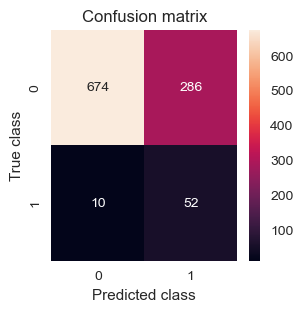

*******************************************************************************
base_estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy train: 0.7220455101541473
Accuracy test: 0.6976516634050881
              precision    recall  f1-score   support

           0       1.00     

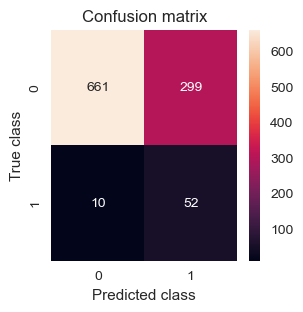

*******************************************************************************
base_estimator: LGBMClassifier()
Accuracy train: 0.722290188402251
Accuracy test: 0.6966731898238747
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      3900
           1       0.14      1.00      0.25       187

    accuracy                           0.72      4087
   macro avg       0.57      0.85      0.54      4087
weighted avg       0.96      0.72      0.80      4087



              precision    recall  f1-score   support

           0       0.99      0.69      0.81       960
           1       0.15      0.84      0.25        62

    accuracy                           0.70      1022
   macro avg       0.57      0.76      0.53      1022
weighted avg       0.93      0.70      0.78      1022



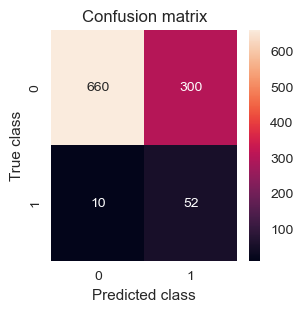

*******************************************************************************
base_estimator: <catboost.core.CatBoostClassifier object at 0x0000016A10EB6650>
Accuracy train: 0.7369708832884757
Accuracy test: 0.726027397260274
              precision    recall  f1-score   support

           0       1.00      0.73      0.84      3900
           1       0.14      0.95      0.25       187

    accuracy                           0.74      4087
   macro avg       0.57      0.84      0.54      4087
weighted avg       0.96      0.74      0.81      4087



              precision    recall  f1-score   support

           0       0.99      0.72      0.83       960
           1       0.16      0.85      0.27        62

    accuracy                           0.73      1022
   macro avg       0.58      0.79      0.55      1022
weighted avg       0.94      0.73      0.80      1022



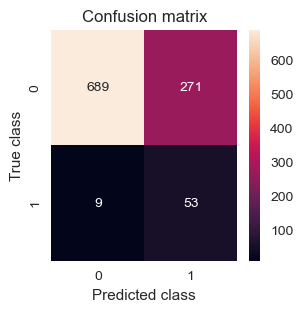

*******************************************************************************
***   R E S U M E N   D E   M É T R I C A S   D E   L O S   M O D E L O S   ***
*******************************************************************************
modelo: RandomForestClassifier(class_weight='balanced')
	acc_train: 0.7293858575972596		acc_test: 0.7103718199608611
	train_1_recall: 1.0	test_1_recall: 0.8225806451612904
	train_1_f1: 0.25270270270270273		test_1_f: 0.2562814070351759
modelo: AdaBoostClassifier()
	acc_train: 0.6794714949840959		acc_test: 0.675146771037182
	train_1_recall: 0.946524064171123	test_1_recall: 0.8548387096774194
	train_1_f1: 0.21274038461538464		test_1_f: 0.24200913242009134
modelo: LogisticRegression()
	acc_train: 0.7313432835820896		acc_test: 0.726027397260274
	train_1_recall: 0.8342245989304813	test_1_recall: 0.7741935483870968
	train_1_f1: 0.22127659574468087		test_1_f: 0.2553191489361702
modelo: DecisionTreeClassifier()
	acc_train: 0.7739172987521409		acc_test: 0.7524

In [74]:
base_estimator_list= [RandomForestClassifier(class_weight= 'balanced'),
                      AdaBoostClassifier(),
                      LogisticRegression(),
                      DecisionTreeClassifier(), 
                      GradientBoostingClassifier(),
                      xgboost.XGBClassifier(),
                      LGBMClassifier(), 
                      CatBoostClassifier(verbose=False)]

modelos_dict = {}

for base_estimator in base_estimator_list:

    print('*******************************************************************************')
    print('base_estimator:', base_estimator)

    param_grid_dict = {
        'base_estimator': [base_estimator],
        'sampling_strategy': ['auto'],
        'replacement': [False],
        'random_state': [0]
    }

    easyens = EasyEnsembleClassifier()

    grid_search_cv = GridSearchCV(easyens, param_grid_dict, n_jobs=8, cv=5)
    grid_search_cv.fit(X_train_scaled, y_train)

    acc_train = accuracy_score(grid_search_cv.predict(X_train_scaled), y_train)
    acc_test = accuracy_score(grid_search_cv.predict(X_test_scaled), y_test)
    print('Accuracy train:', acc_train)
    print('Accuracy test:', acc_test)

    y_pred_train_easyens=grid_search_cv.predict(X_train_scaled)


    y_pred_test_easyens= grid_search_cv.predict(X_test_scaled)

    target_names = ['0','1'] 

    classification_report_train = classification_report(y_train, y_pred_train_easyens, target_names=target_names, output_dict=True)
    classification_report_test = classification_report(y_test, y_pred_test_easyens, target_names=target_names, output_dict=True)

    print(classification_report(y_train, y_pred_train_easyens, target_names=target_names, output_dict=False))
    print('\n')
    print(classification_report(y_test, y_pred_test_easyens, target_names=target_names, output_dict=False))

    modelos_dict[f'{base_estimator}'] = {'acc_train': acc_train, 'acc_test': acc_test,
                                         'train_1_recall': classification_report_train['1']['recall'],
                                         'train_1_f1': classification_report_train['1']['f1-score'],
                                         'test_1_recall': classification_report_test['1']['recall'],
                                         'test_1_f1': classification_report_test['1']['f1-score']}

    resultados(y_test, y_pred_test_easyens)

print('*******************************************************************************')
print('***   R E S U M E N   D E   M É T R I C A S   D E   L O S   M O D E L O S   ***')
print('*******************************************************************************')
for modelo in modelos_dict.keys():
    acc_train = modelos_dict[modelo]['acc_train']
    acc_test = modelos_dict[modelo]['acc_test']
    train_1_recall = modelos_dict[modelo]['train_1_recall']
    train_1_f1 = modelos_dict[modelo]['train_1_f1']
    test_1_recall = modelos_dict[modelo]['test_1_recall']
    test_1_f1 = modelos_dict[modelo]['test_1_f1']
    print(f'modelo: {modelo}')
    print(f'\tacc_train: {acc_train}\t\tacc_test: {acc_test}')
    print(f'\ttrain_1_recall: {train_1_recall}\ttest_1_recall: {test_1_recall}')
    print(f'\ttrain_1_f1: {train_1_f1}\t\ttest_1_f: {test_1_f1}')

### Métodos de ensamblaje: BalancedRandomForestClassifier

              precision    recall  f1-score   support

           0       1.00      0.74      0.85      3900
           1       0.16      1.00      0.27       187

    accuracy                           0.75      4087
   macro avg       0.58      0.87      0.56      4087
weighted avg       0.96      0.75      0.82      4087



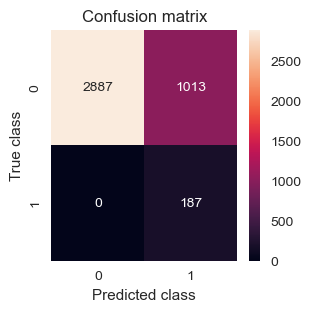



              precision    recall  f1-score   support

           0       0.98      0.72      0.83       960
           1       0.16      0.79      0.26        62

    accuracy                           0.73      1022
   macro avg       0.57      0.76      0.55      1022
weighted avg       0.93      0.73      0.80      1022



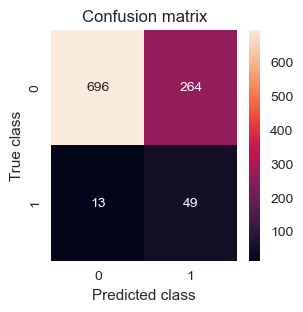

In [75]:
brdm=BalancedRandomForestClassifier(n_estimators=100, class_weight='balanced')

brdm.fit(X_train_scaled, y_train)

y_pred_train_brdm=brdm.predict(X_train_scaled)


y_pred_test_brdm = brdm.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_brdm, target_names=target_names))


resultados(y_train, y_pred_train_brdm)

print('\n')


target_names = ['0','1']
print(classification_report(y_test, y_pred_test_brdm, target_names=target_names))

resultados(y_test, y_pred_test_brdm)

### Mejor modelo: EasyEnsembleClassfier con Catboost y GSCV

In [76]:
param_grid_dict = {
    'base_estimator': [CatBoostClassifier(verbose=False, n_estimators=30)],
    'sampling_strategy': ['not minority'],
    'replacement': [True],
    'random_state': [0],
}

easyesem = EasyEnsembleClassifier()

easyesemcv = GridSearchCV(easyesem, param_grid_dict, n_jobs=8, cv=5)
easyesemcv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=EasyEnsembleClassifier(), n_jobs=8,
             param_grid={'base_estimator': [<catboost.core.CatBoostClassifier object at 0x0000016A12D892D0>],
                         'random_state': [0], 'replacement': [True],
                         'sampling_strategy': ['not minority']})

In [77]:
easyesemcv.best_params_

{'base_estimator': <catboost.core.CatBoostClassifier at 0x16a12d892d0>,
 'random_state': 0,
 'replacement': True,
 'sampling_strategy': 'not minority'}

In [78]:
best_easyesemcv=easyesemcv.best_estimator_

In [79]:
best_easyesemcv.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x0000016A0F36E950>,
                       random_state=0, replacement=True,
                       sampling_strategy='not minority')

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      3900
           1       0.12      0.88      0.22       187

    accuracy                           0.71      4087
   macro avg       0.56      0.79      0.52      4087
weighted avg       0.95      0.71      0.79      4087



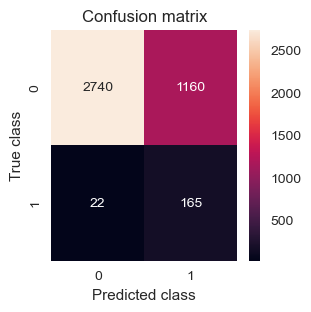



              precision    recall  f1-score   support

           0       0.99      0.68      0.81       960
           1       0.16      0.90      0.27        62

    accuracy                           0.70      1022
   macro avg       0.57      0.79      0.54      1022
weighted avg       0.94      0.70      0.78      1022



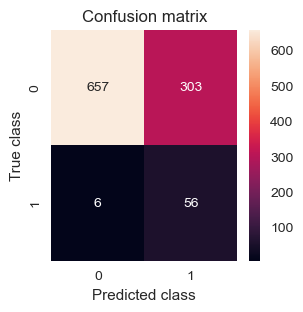

In [80]:
y_pred_train_best_easyesemcv=best_easyesemcv.predict(X_train_scaled)


y_pred_test_best_easyesemcv = best_easyesemcv.predict(X_test_scaled)

target_names = ['0','1'] 
print(classification_report(y_train, y_pred_train_best_easyesemcv, target_names=target_names))

resultados(y_train, y_pred_train_best_easyesemcv)

print('\n')


target_names = ['0','1']
print(classification_report(y_test, y_pred_test_best_easyesemcv, target_names=target_names))


resultados(y_test, y_pred_test_best_easyesemcv)

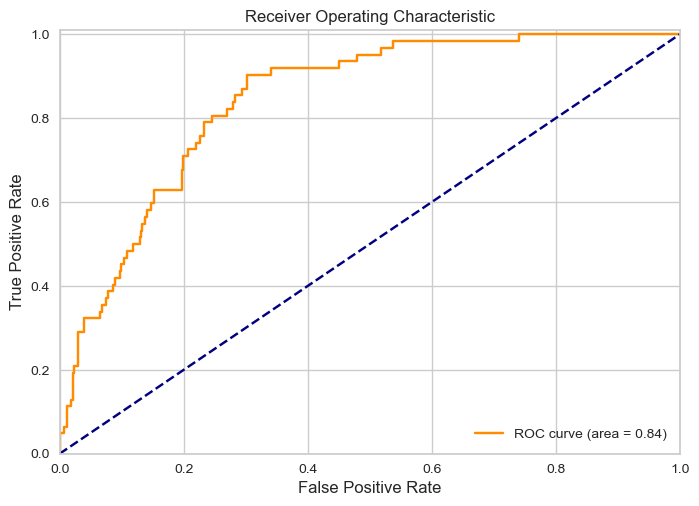

In [81]:
predictions = best_easyesemcv.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [82]:
# # Guardamos el modelo
# modeloEasyCatboostcv='EasyEnsembleCatboostcv.model'
# with open(modeloEasyCatboostcv, "wb") as archivo_salida:
#     pickle.dump(best_easyesemcv, archivo_salida)